In [1]:
#import packages
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr
import functools as ft
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry
import xskillscore as xs
from sklearn.linear_model import LinearRegression


In [2]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [3]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],# reduce along 'model'
                        )
    return slope

In [4]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [5]:
def get_model_DS(MODS, v1, v2, lat, lat_r, lon, lon_r):
    for i, model in enumerate(MODS.keys()):
        HB = MODS[model]
        v1a = HB[v1]
        v2a = HB[v2]
        if len(v1a.coords) > 3:
            #print(v1a.coords)
            v1a = v1a.drop_vars('lev')
        if len(v2a.coords) >3:
            v2a = v2a.drop_vars('lev')
        if v2 == 'wcur':
            v2a = v2a.groupby('time.month').mean('time')
        v1a = get_region(v1a, lat, lat_r, lon, lon_r)
        v2a = get_region(v2a, lat, lat_r, lon, lon_r)


        v1a = v1a.assign_coords({"model":model})
        v2a = v2a.assign_coords({"model":model})
        if i == 0:
            v1m = v1a
            v2m = v2a
        else:
            v1m = xr.concat([v1m, v1a], dim = 'model')
            #print(v2a, model)
            v2m = xr.concat([v2m, v2a], dim = 'model')
    DS = xr.Dataset(data_vars=dict(
            v1m=(["model", "month"], v1m),
            v2m=(["model", "month"], v2m)),
        coords=dict(
            month=(v1m.month),
            model=(v1m.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    DS = DS.rename({'v1m':v1, 'v2m':v2})
    return DS

In [6]:
#load in data
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'lw':'_netLW.nc', 'sw':'_netSW.nc', 'lhf':'_hfls.nc', 
             'shf':'_hfss.nc', 'SST': '_tos.nc', 'dtdx':'_dtx.nc', 'dtdy':'_dty.nc', 'dtdz':'_dtz.nc',
             'wcur':'_wcur.nc', 'vcur':'_vcur.nc', 'ucur':'_ucur.nc', 
             'uw':'_tauu.nc', 'vw':'_tauv.nc','wspd':'_wspd.nc', 'wsc':'_wsc.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netLW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netSW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfls.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfss.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_f

In [7]:
#load in REAn products with all HB terms
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/REAN_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'Q':'_qnet.nc', 'lw':'_lwrf.nc', 'sw':'_swrf.nc', 'lhf':'_lhf.nc', 
             'shf':'_shf.nc', 'SST': '_tos.nc', 'dtdx':'_dtx.nc', 'dtdy':'_dty.nc', 'dtdz':'_dtz.nc',
             'wcur':'_wcur.nc', 'vcur':'_vcur.nc', 'ucur':'_ucur.nc', 
             'uw':'_tauu.nc', 'vw':'_tauv.nc','wspd':'_wspd.nc','wsc':'_wsc.nc'}
OBS={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    mod={}
    for key in varis.keys():
        #input file
        inp_files = (os.path.join(datadir, model, str(model+varis[key])))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #put into dict
            mod[key]=var
            OBS[model] = mod

        except Exception as e:
            print(e)
            mod[key]=0
            OBS[model] = mod
            pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_lwrf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_swrf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_lhf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_shf.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN

In [8]:
#reverse signs on advection, pack Qnet nad HF terms separately
OBS1={}
for model in OBS.keys():
    HB = OBS[model]
    try:
        T=HB['dTdt']*(3986*1026*50)
        U=HB['ua']*(3986*1026*50)
        V=HB['va']*(3986*1026*50)
        W=HB['wa']*(3986*1026*50)
        lw=HB['lw']
        sw=HB['sw']
        lhf=HB['lhf']
        shf=HB['shf']
        if model == 'ERA5':
            Q=(lw+sw+lhf+shf)#terms are all positive so have to add in sign, and scale to degC/month
        elif model == 'OAFLUX':
            Q = HB['Q']
        else:
            Q = HB['Q']*(3986*1026*50)
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict with correct sign so everything is additive
        HB.update({'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'Q':Q, 'res':resid, 'SST':SST, 
             'lw':lw, 'sw':sw, 'lhf':lhf, 'shf':shf,})
        #update models dictionary
        OBS.update({model:HB})
    except Exception as e:
        print(e, model)


In [9]:
#reverse signs on advection, pack Qnet nad HF terms separately
models1={}
model_HF={}
for model in models.keys():
    try:
        HB=models[model]
        T=HB['dTdt']*(3986*1026*50)
        U=HB['ua']*(3986*1026*50)
        V=HB['va']*(3986*1026*50)
        W=HB['wa']*(3986*1026*50)
        lw=HB['lw']
        sw=HB['sw']
        lhf=HB['lhf']
        shf=HB['shf']
        Q=(lw+sw-lhf-shf)#terms are all positive so have to add in sign, and scale to degC/month
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict with correct sign so everything is additive
        HB.update({'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'Q':Q, 'res':resid, 'SST':SST, 
             'lw':lw, 'sw':sw, 'lhf':-lhf, 'shf':-shf,})
        #update models dictionary
        models.update({model:HB})
    except Exception as e:
        print(e, model)


In [10]:
#define markers for scatter plots
marks = ['o', '+', 'x', '*', '.']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
test ={}
count = 0
for col in colors:
    for mark in marks:
        test[count] = [mark, col]
        count = count+1

In [11]:
sortedkeys=sorted(models.keys(), key=lambda x:x.lower())
LGND={}
for i, name in enumerate(sortedkeys):
    LGND[name] = test[i]

In [12]:
#LGND['MMM'] = ['s', 'white']

In [13]:
colorso = ['c', 'y', 'm', 'b', 'r', 'gray']

In [14]:
LGNDO={}
for i, name in enumerate(OBS.keys()):
    LGNDO[name] = colorso[i]

In [15]:
def plot_scatter(DS, month):
    plt.figure()
    for i, name in enumerate(DS.model.values):
        plt.scatter(DS[list(DS.keys())[0]][i, month],DS[list(DS.keys())[1]][i, month], c=test[i][1], marker=test[i][0], label = name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:,month].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:, month].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:, month].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    plt.plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    #              get_region(SSTB, lat, latr, lon, lonr)[:, month], dim = 'model')

    #plt.text(bbox_to_anchor=(0.05, 1), str(regr.coef_[:3]))
    plt.title('Month = '+str(month+1)+'\n regression coefficient = '+str(regr.coef_[0][0])+'\n Pearson r = '+str(r.values[month])+' p = '+str(p.values[month]))
    plt.xlabel(list(DS.keys())[0])
    plt.ylabel(list(DS.keys())[1])
    return

Plotting here the WTIO scatter plots in June:  
ucurrent vwind  
ucurrent uwind  
uadv DTdt  
vwind LHF  
uwinf LHF  

In [16]:
#define markers for scatter plots OBS
colorso = ['c', 'y', 'm', 'b', 'r', 'gray']

In [17]:
def get_model_DS(MODS, v1, v2, lat, lat_r, lon, lon_r):
    sortedkeys=sorted(MODS.keys(), key=lambda x:x.lower())
    for i, model in enumerate(sortedkeys):
        HB = MODS[model]
        v1a = HB[v1]
        v2a = HB[v2]
        if len(v1a.coords) > 3:
            #print(v1a.coords)
            v1a = v1a.drop_vars('lev')
        if len(v2a.coords) >3:
            v2a = v2a.drop_vars('lev')
        if v2 == 'wcur':
            v2a = v2a.groupby('time.month').mean('time')
        v1a = get_region(v1a, lat, lat_r, lon, lon_r)
        v2a = get_region(v2a, lat, lat_r, lon, lon_r)


        v1a = v1a.assign_coords({"model":model})
        v2a = v2a.assign_coords({"model":model})
        if i == 0:
            v1m = v1a
            v2m = v2a
        else:
            v1m = xr.concat([v1m, v1a], dim = 'model')
            #print(v2a, model)
            v2m = xr.concat([v2m, v2a], dim = 'model')
    DS = xr.Dataset(data_vars=dict(
            v1m=(["model", "month"], v1m),
            v2m=(["model", "month"], v2m)),
        coords=dict(
            month=(v1m.month),
            model=(v1m.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    DS = DS.rename({'v1m':v1, 'v2m':v2})
    return DS

In [18]:
def test_fn(MODS,obs, v1, v2, lat, lat1, lon, lon1, month):
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    a = plot_scatter(DS, month)
    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
            Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
            plt.scatter(Ox[month], Oy[month], edgecolors = 'k', facecolors=colorso[i], label = prod)
        except Exception as e:
            print(e, 'one doesnt exist')
        try:
            if obs[prod][v1] == int(0):
                Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
                plt.axhline(Oy[month], c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            print('no data v1', prod)
        try:
            if obs[prod][v2] == int(0):
                Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
                plt.axvline(Ox[month], c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            print('no data v2', prod)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return

In [19]:
def test_fn2(MODS,obs, v1, v2, lat, lat1, lon, lon1, month):
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    return r,p

In [20]:
def test_fn3(MODS,obs, v1, v2, lat, lat1, lon, lon1, month):#for supp figures
    plt.figure(figsize=(8,6))
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    DS = DS.sel(month=month).mean('month')
    DSM = DS.median('model')
    for i, name in enumerate(DS.model.values):
        plt.scatter(DS[list(DS.keys())[0]][i],DS[list(DS.keys())[1]][i], c=test[i][1], marker=test[i][0], label = name)
    plt.scatter(DSM[list(DS.keys())[0]], DSM[list(DS.keys())[1]], marker = 's', edgecolors = 'k', c = 'white', label = 'MMM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    plt.plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    plt.title('slope = '+
              f'{regr.coef_[0][0]:.2f}'+
              '\n Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}')

    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
            Ox = Ox.sel(month=month).mean('month')
            Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
            Oy = Oy.sel(month=month).mean('month')
            plt.scatter(Ox, Oy, marker = 's', facecolors=colorso[i], label = prod)
        except Exception as e:
            pass
        try:
            if obs[prod][v1] == int(0):
                Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
                Oy = Oy.sel(month=month).mean('month')
                plt.axhline(Oy, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
        try:
            if obs[prod][v2] == int(0):
                Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
                Ox = Ox.sel(month=month).mean('month')
                plt.axvline(Ox, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
    
    
    return DS

In [21]:
def test_fn5(MODS,obs, d, v1, v2, lat, lat1, lon, lon1, month):
    title_dict = {1:'a',2:'b', 3:'c', 4:'d'}
    
    DS = get_model_DS(MODS, v1, v2, lat, lat1, lon, lon1)
    DS = DS.sel(month=month).mean('month')
    DSM = DS.median('model')
    for i, name in enumerate(DS.model.values):
        axs[d].scatter(DS[list(DS.keys())[0]][i],DS[list(DS.keys())[1]][i], c=test[i][1], marker=test[i][0], s = 53, label = name)
    axs[d].scatter(DSM[list(DS.keys())[0]], DSM[list(DS.keys())[1]], marker = 's', edgecolors = 'k', c = 'white', s = 53,label = 'MMM')
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    axs[d].plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    axs[d].set_title(title_dict[d+1]+')\n slope = '+
              f'{regr.coef_[0][0]:.2f}'+
              '\n Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}', loc='left')
    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
            Ox = Ox.sel(month=month).mean('month')
            Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
            Oy = Oy.sel(month=month).mean('month')
            axs[d].scatter(Ox, Oy, marker = 's', facecolors=colorso[i], s = 53,label = prod)
        except Exception as e:
            pass
        try:
            if obs[prod][v1] == int(0):
                Oy = get_region(obs[prod][v2], lat, lat1, lon, lon1)
                Oy = Oy.sel(month=month).mean('month')
                axs[d].axhline(Oy, c = colorso[i], linewidth = 0.5, linestyle = '-', label = prod)
        except:
            pass
        try:
            if obs[prod][v2] == int(0):
                Ox = get_region(obs[prod][v1], lat, lat1, lon, lon1)
                Ox = Ox.sel(month=month).mean('month')
                axs[d].axvline(Ox, c = colorso[i], linewidth = 0.5, linestyle = '-', label = prod)
        except:
            pass
    return

In [22]:
def test_fn_gpt(MODS, obs, v1, v2, v3, v4, v5, v6, v7, v8, lat, lat1, lon, lon1, m1,m2,m3,m4):
    axes=[]
    fig = plt.figure(figsize=(12,10))
    variables = [v1, v2, v3, v4, v5, v6, v7, v8]
    months = [m1,m2,m3,m4]
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn4(MODS,obs, v1, v2, lat, lat1, lon, lon1, month)
        plt.xlabel(var_titles[v1])
        plt.ylabel(var_titles[v2])
        axes.append(ax)
    plt.tight_layout()
    legend_without_duplicate_labels(axes)
    #fig.legend(loc='lower center', ncol=4, mode='expand')    

    return 

In [23]:
def test_fn_gpt2(MODS, obs, v1, v2, v3, v4, v5, v6, v7, v8, lat, lat1, lon, lon1, m1,m2,m3,m4):
    variables = [v1, v2, v3, v4, v5, v6, v7, v8]
    months = [m1,m2,m3,m4]
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    #axs = axs.ravel()
    for i in range(4):
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        print(i, v1,v2,month)
        test_fn5(MODS,obs, i, v1, v2, lat, lat1, lon, lon1, month)
        #axs[i].set_xlabel(var_titles[v1])
        #axs[i].set_ylabel(var_titles[v2])
        #axes.append(ax)
    #plt.tight_layout()
    #legend_without_duplicate_labels(axes)
    #fig.legend(loc='lower center', ncol=4, mode='expand')    

    return

In [24]:
var_titles={'dTdt':'$dT/dt$ ($Wm^{-2}$)', 'ua':'U advection ($Wm^{-2}$)', 'va':'V advection ($Wm^{-2}$)',
             'wa':'W advection ($Wm^{-2}$)', 'Q':'Qnet ($Wm^{-2}$)', 'lw':'longwave radiation ($Wm^{-2}$)',
            'sw':'shortwave radiation ($Wm^{-2}$)', 'lhf':'Latent heat flux ($Wm^{-2}$)', 
             'shf':'Sensible heat flux ($Wm^{-2}$)', 'SST': 'SST degC', 
             'wcur':'Vertical flow ($ms^{-1}$)', 'vcur':'Meridional flow ($ms^{-1}$)', 'ucur':'Zonal flow ($ms^{-1}$)', 
             'uw':'Zonal wind stress ($Nm^{-2}$)', 'vw':'Meridonal wind stress ($Nm^{-2}$)','wspd':'Wind stress ($Nm^{-2}$)'}

In [25]:
#define legend stuff
handles = []
labels = []
for label, marker_color in LGND.items():
    marker, color = marker_color
    handles.append(plt.Line2D([], [], marker=marker, markersize = 10, color=color, linestyle='None'))
    labels.append(label)
for label, marker_color in LGNDO.items():
    handles.append(plt.Line2D([0], [0], marker = 's',  color=marker_color, lw=0.5))
    labels.append(label)

In [26]:
handles.append(plt.Line2D([], [], marker='s', color='white', markeredgecolor = 'k', linestyle='None'))
labels.append('MMM')

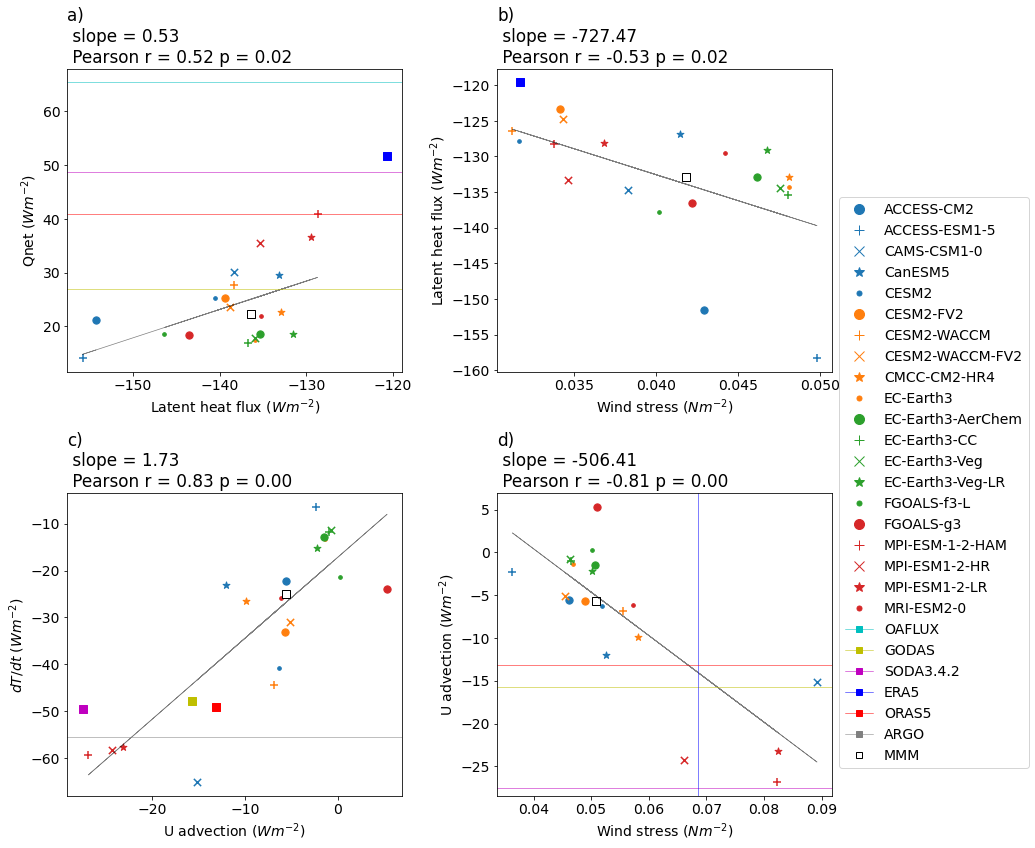

In [75]:
#figure 4
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf', 'Q','wspd', 'lhf','ua', 'dTdt','wspd', 'ua']
months = [[7,8,9,10,11,12,1,2,3,4],[12,1,2,3,4],[5,6],[5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,10,50,70, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend|
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_4.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')


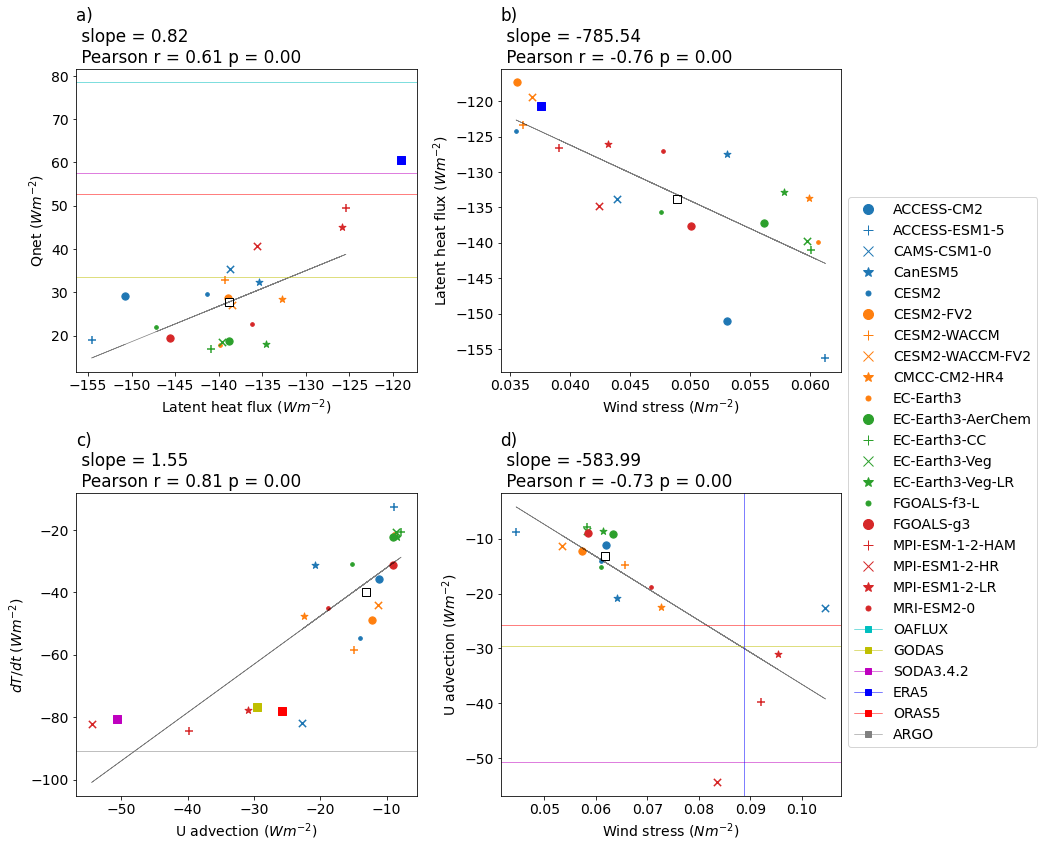

In [26]:
#figure 4 but for closer to somali coast
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf', 'Q','wspd', 'lhf','ua', 'dTdt','wspd', 'ua']
months = [[7,8,9,10,11,12,1,2,3,4],[12,1,2,3,4],[5,6],[5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,10,45,60, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend|
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_4.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')


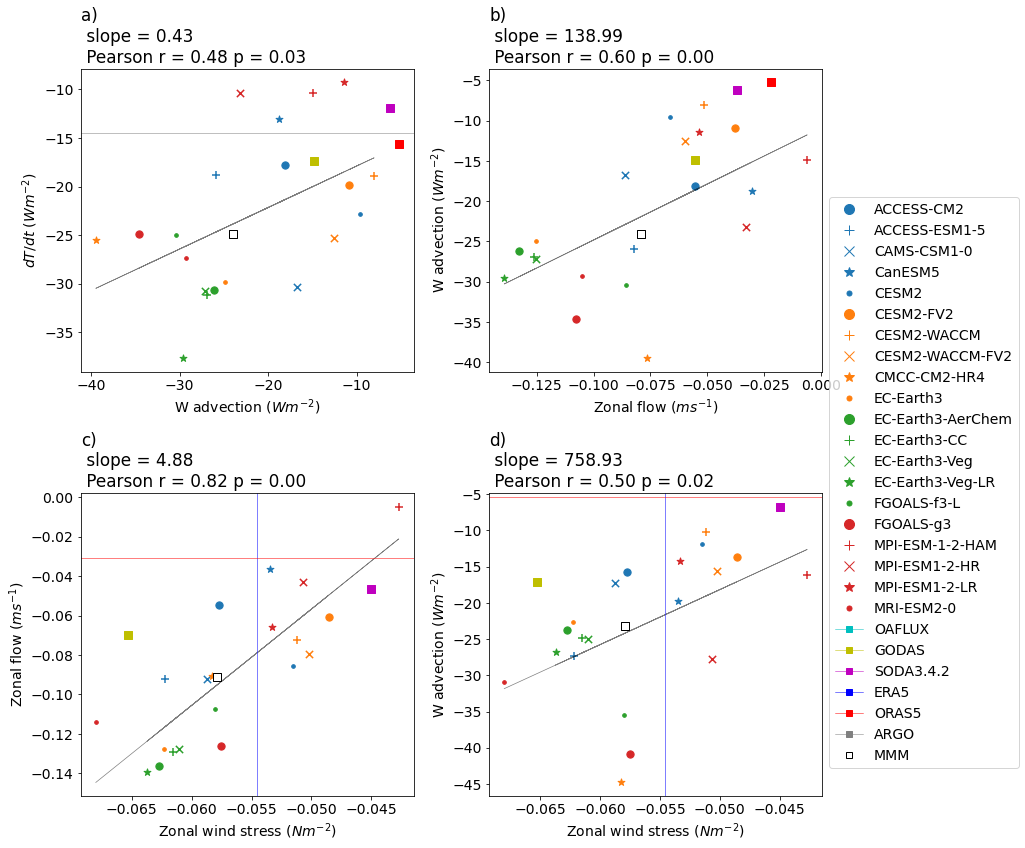

In [76]:
#figure 6
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['wa', 'dTdt','ucur', 'wa','uw', 'ucur','uw', 'wa']
months = [[7,8,9,10],[7,8,9,10],[7,8,9],[7,8,9]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,0,90,110, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-05-26/F_6.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_6.png', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

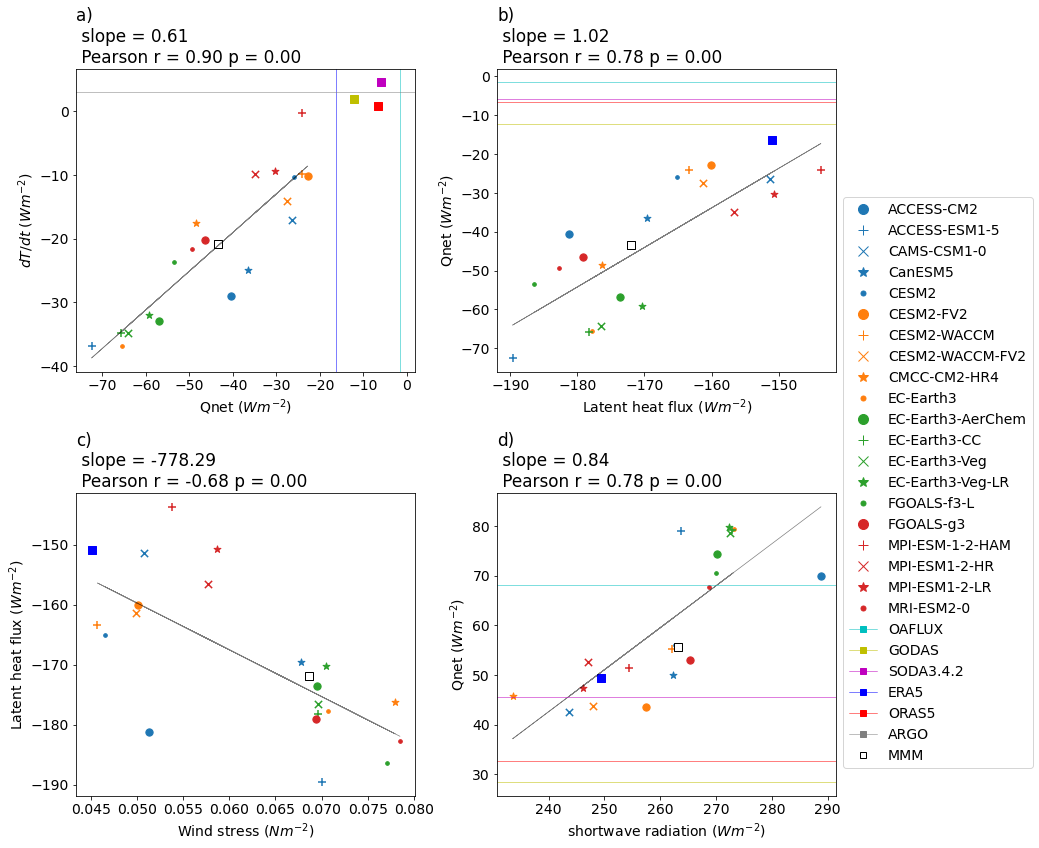

In [77]:
#figure 8
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['Q', 'dTdt','lhf', 'Q','wspd', 'lhf','sw', 'Q']
months = [[11,12,1,2,3],[11,12,1,2,3],[11,12,1,2,3],[4,5,6,7]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, 10,20,50,70, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/F_8.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/F_8.png', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

In [39]:
#now create supplementary figures 

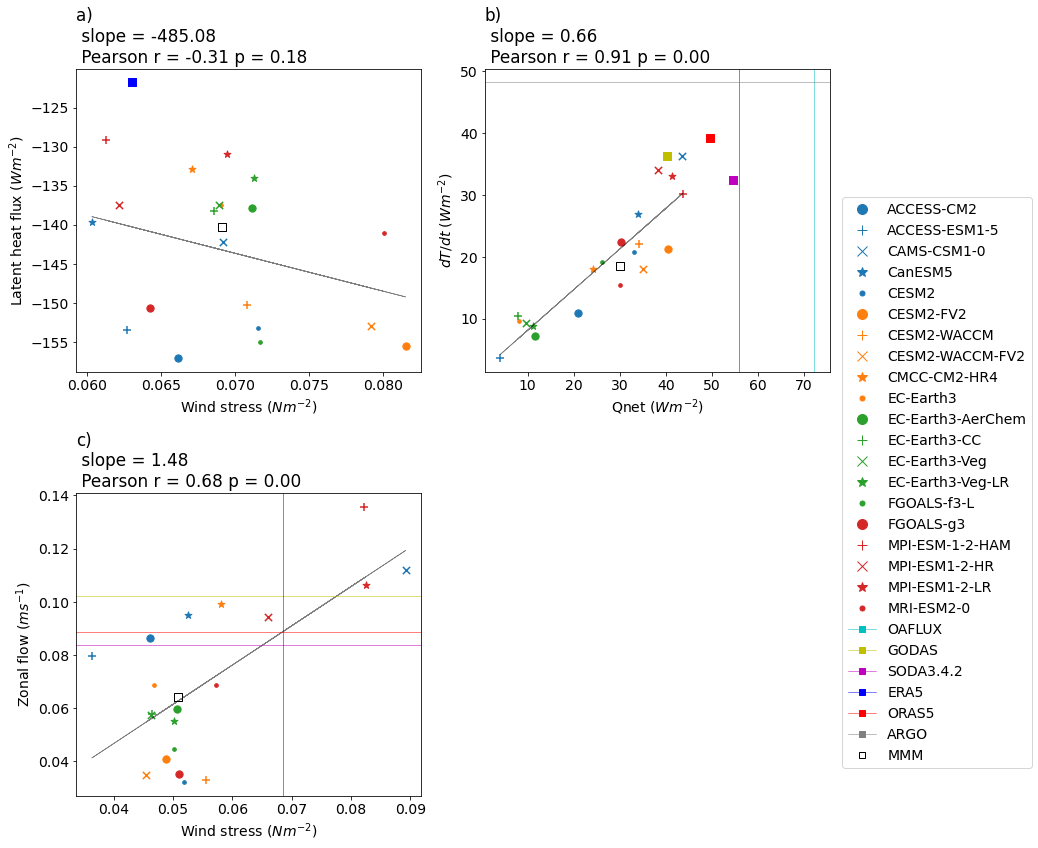

In [82]:
#WTIO SUPP FIG
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['wspd', 'lhf','Q', 'dTdt','wspd', 'ucur']
months = [[7,8,9,10,11],[1,2,3],[5,6]]
for i in range(4):
    if i ==3:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, -10,10,50,70, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
fig.delaxes(axs[3])
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N1.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

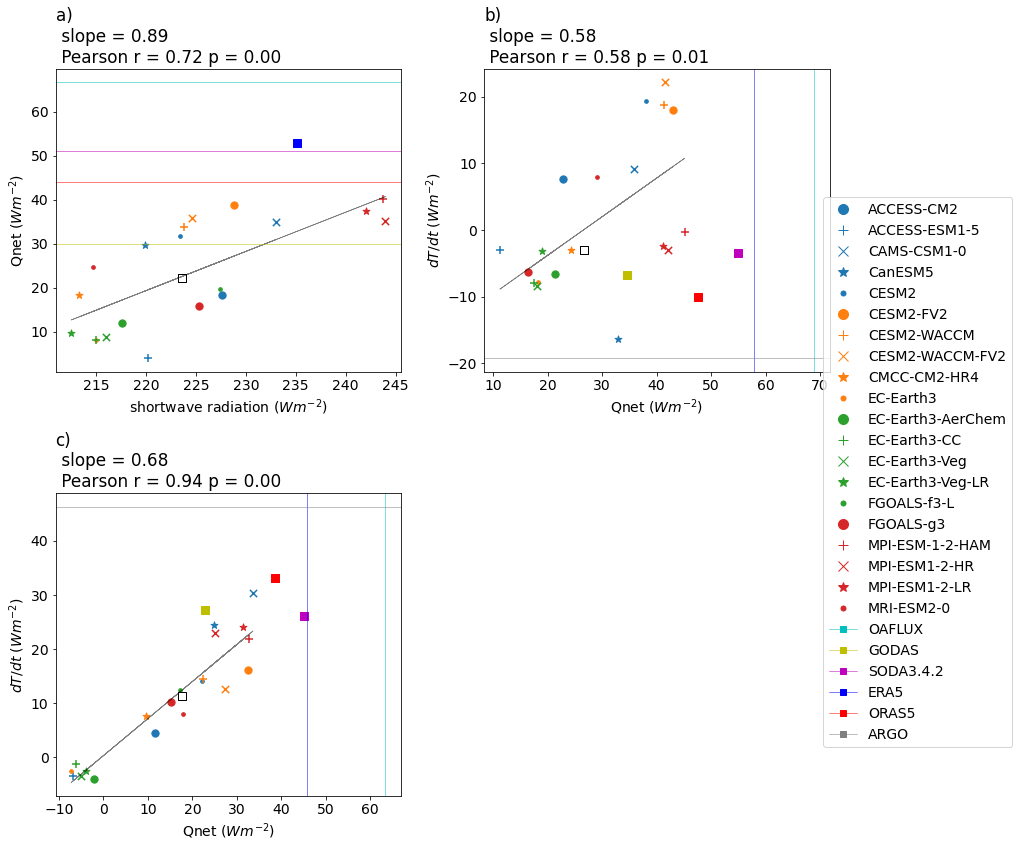

In [37]:
#WTIO SUPP FIG ###investigating SW
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['sw', 'Q','Q', 'dTdt','Q', 'dTdt']
months = [[1,2,10,11,12],[10,11,12],[1,2]]
for i in range(4):
    if i ==3:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, -10,10,50,70, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
fig.delaxes(axs[3])
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N1.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

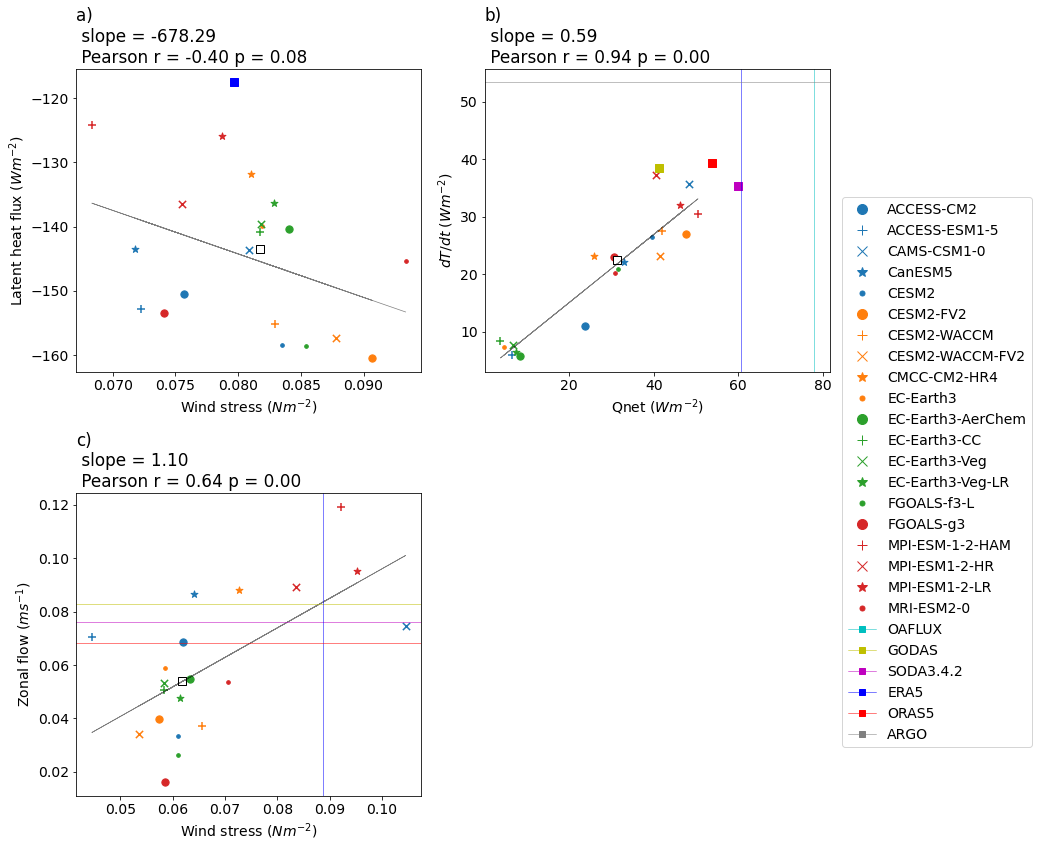

In [27]:
#WTIO SUPP FIG ###SOMALI region
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['wspd', 'lhf','Q', 'dTdt','wspd', 'ucur']
months = [[7,8,9,10,11],[1,2,3],[5,6]]
for i in range(4):
    if i ==3:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, -10,10,45,60, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
fig.delaxes(axs[3])
plt.legend(handles, labels, bbox_to_anchor=(2.2, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N1.eps', pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N4.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

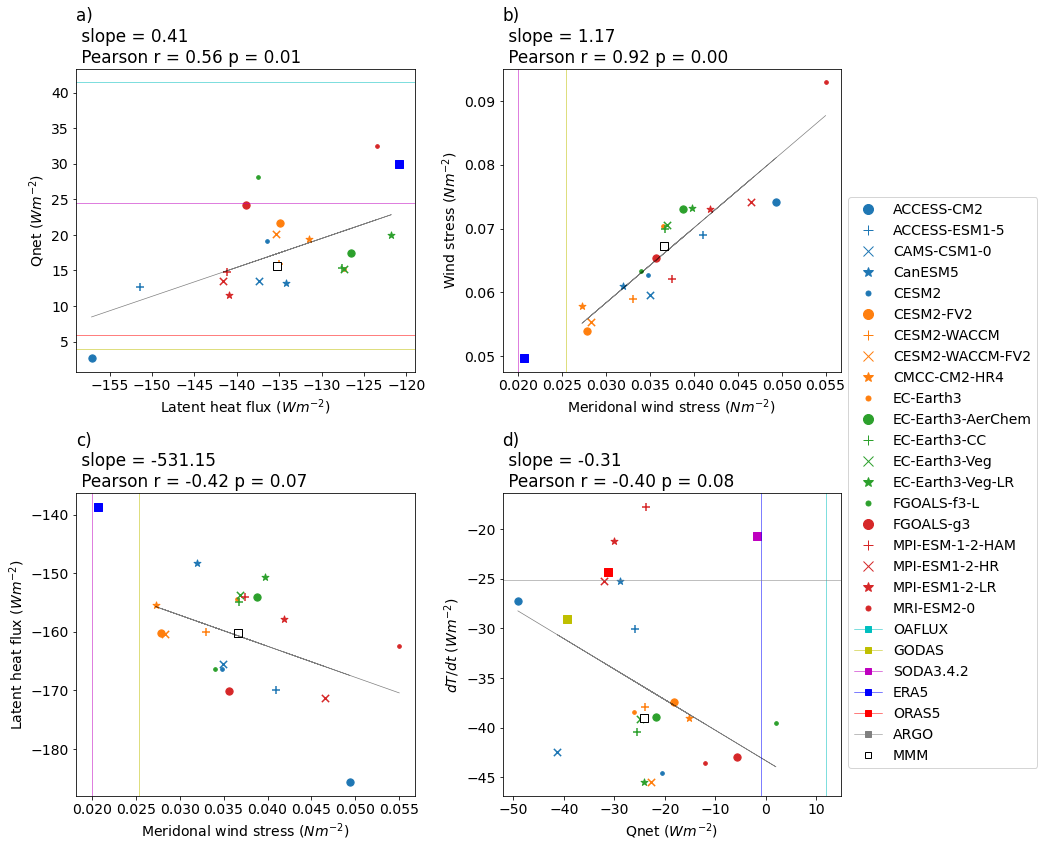

In [83]:
#SETIO SUPP FIG
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['lhf','Q', 'vw','wspd', 'vw', 'lhf', 'Q', 'dTdt']
months = [[1,2,3,4,5,6,7,8,9,10,11,12],[6,7],[6,7],[6,7,8,9]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,0,90,110, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
    plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N2.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N5.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

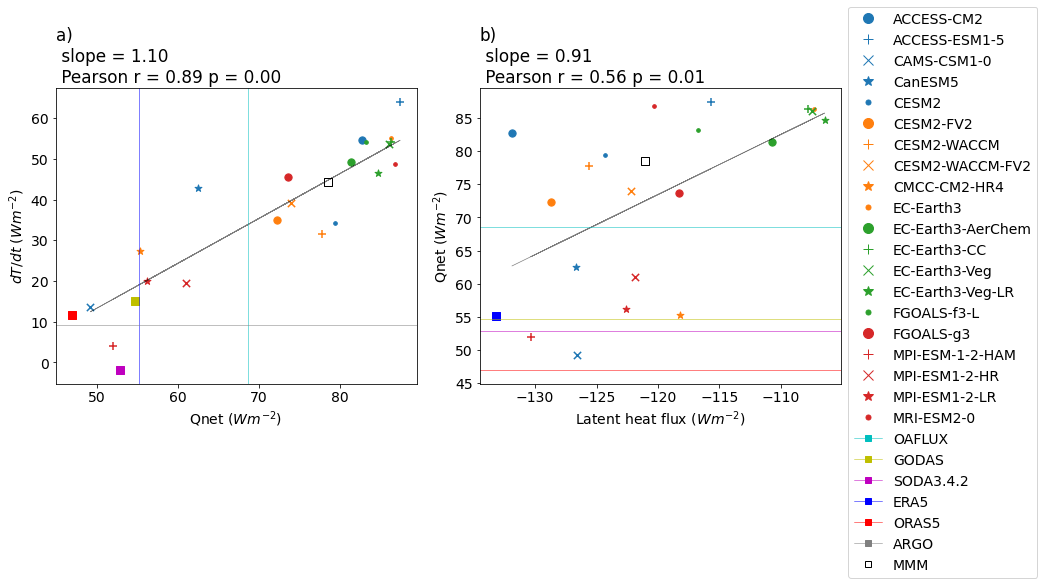

In [84]:
#Arabian Sea SUPP FIG
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()
variables = ['Q','dTdt', 'lhf','Q']
months = [[4,5,6],[4,5,6]]
for i in range(4):
    if i>1:
        pass
    else:
        v1 = variables[i*2]
        v2 = variables[i*2 + 1]
        month = months[i]
        test_fn5(models,OBS, i, v1, v2, 10,20,50,70, month)
        axs[i].set_xlabel(var_titles[v1])
        axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()
# Create the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 1.3), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_N3.eps', pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N7.png', dpi = 600,pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

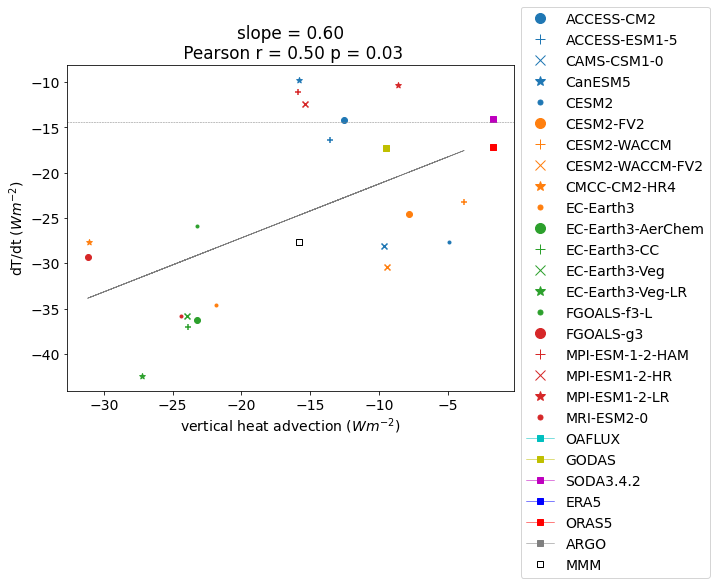

In [85]:
#suppfig_6
#smaller SETIO 100E, Q dt Jul-Oct
TA = test_fn3(models, OBS,  'wa', 'dTdt', -10,0,90,100, [7,8,9,10])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('vertical heat advection ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')

plt.savefig('/home/z5113258/Documents/figures/Figures_high_res/SF_N6.png', dpi=600, 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

In [53]:
def plot_SST_2regions(MODS,obs, lat, lat1, lon, lon1, lat21, lat22, lon21, lon22, month, month2):#for supp figures
    plt.figure(figsize=(8,6))
    DS = get_model_DS(MODS, 'SST', "ua", lat, lat1, lon, lon1)
    DS = DS.sel(month=month).mean('month')
    DSM = DS.median('model')
    DS1 = get_model_DS(MODS, 'ua', "SST", lat21, lat22, lon21, lon22)
    DS1 = DS1.sel(month=month2).mean('month')
    DSM1 = DS1.median('model')    
    
    for i, name in enumerate(DS.model.values):
        plt.scatter(DS[list(DS.keys())[0]][i],DS1[list(DS1.keys())[1]][i], c=test[i][1], marker=test[i][0], label = name)
    plt.scatter(DSM[list(DS.keys())[0]], DSM1[list(DS1.keys())[1]], marker = 's', edgecolors = 'k', c = 'white', label = 'MMM')
    
    regr = LinearRegression().fit(DS[list(DS.keys())[0]][:].values.reshape(-1, 1),
                                  DS1[list(DS1.keys())[1]][:].values.reshape(-1, 1))
    x = DS[list(DS.keys())[0]][:].values.reshape(-1, 1)
    m = regr.coef_
    b= regr.intercept_
    plt.plot(x, (m*x + b), c = 'k', alpha = 0.5, lw = 0.7)
    r = xs.pearson_r(DS[list(DS.keys())[0]], DS[list(DS.keys())[1]], dim = 'model')
    p = xs.pearson_r_p_value(DS[list(DS.keys())[0]], DS1[list(DS1.keys())[1]], dim = 'model')
    plt.title('slope = '+
              f'{regr.coef_[0][0]:.2f}'+
              '\n Pearson r = '+f'{r.values:.2f}'+
              ' p = '+f'{p.values:.2f}')

    for i, prod in enumerate(obs.keys()):
        try:
            Ox = get_region(obs[prod]['SST'], lat, lat1, lon, lon1)
            Ox = Ox.sel(month=month).mean('month')
            Oy = get_region(obs[prod]['SST'], lat, lat1, lon, lon1)
            Oy = Oy.sel(month=month2).mean('month')
            plt.scatter(Ox, Oy, marker = 's', facecolors=colorso[i], label = prod)
        except Exception as e:
            pass
        try:
            if obs[prod]['SST'] == int(0):
                Oy = get_region(obs[prod]['SST'], lat, lat1, lon, lon1)
                Oy = Oy.sel(month=month2).mean('month')
                plt.axhline(Oy, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
        try:
            if obs[prod]['SST'] == int(0):
                Ox = get_region(obs[prod]['SST'], lat, lat1, lon, lon1)
                Ox = Ox.sel(month=month).mean('month')
                plt.axvline(Ox, c = colorso[i], linewidth = 0.5, linestyle = '--', label = prod)
        except:
            pass
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    
    return DS

Text(0, 0.5, 'AS SST MAM')

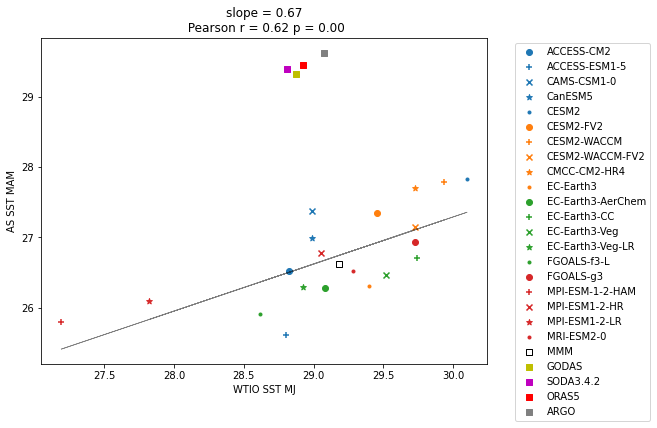

In [58]:
a = plot_SST_2regions(models, OBS, -10,10,50,70, 10,20,50,70, [5,6], [3,4,5])
plt.xlabel("WTIO SST MJ")
plt.ylabel("AS SST MAM")

Text(0.5, 0, 'SETIO SST SON')

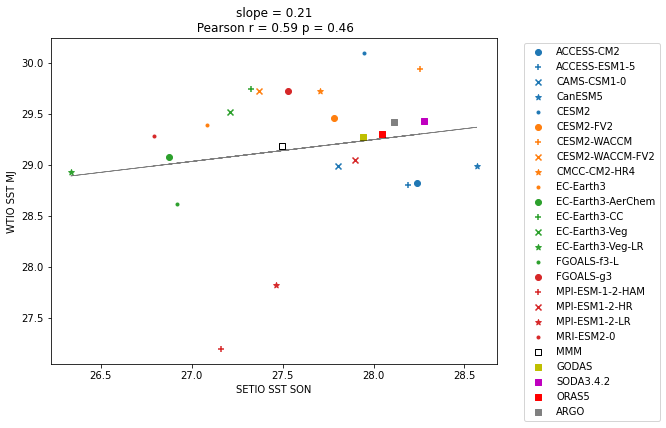

In [59]:
a = plot_SST_2regions(models, OBS,  -10,0,90,110, -10,10,50,70, [8,9,10], [5,6])
plt.ylabel("WTIO SST MJ")
plt.xlabel("SETIO SST SON")

In [31]:
models['ACCESS-CM2']["SST"]

<xarray.DataArray 'tos' (month: 12, lat: 60, lon: 95)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 17.552269, 18.641138],
        [      nan,       nan, ..., 15.830636, 15.393892]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 16.155424, 17.48786 ],
        [      nan,       nan, ..., 14.073252, 13.626736]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 21.665703, 21.453081],
        [      nan,       nan, ..., 20.897768, 20.398783]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 19.60295 , 19.972794],
        [      nan,       nan, ..., 18.417376, 17.953798]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


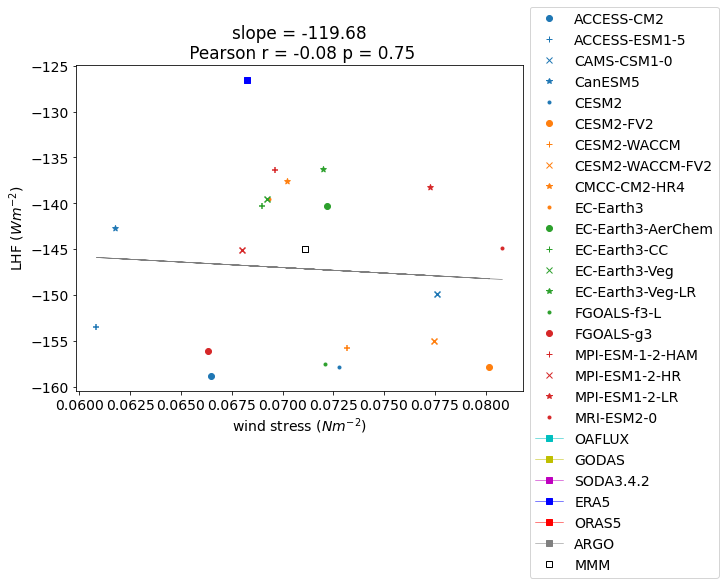

In [239]:
#supp fig 4
#WTIO June-Nov wind:LHF
TA = test_fn3(models, OBS,  'wspd', 'lhf', -10,10,50,70, [6,7,8,9,10,11])
plt.ylabel('LHF ($Wm^{-2}$)')
plt.xlabel('wind stress ($Nm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_4.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF4.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


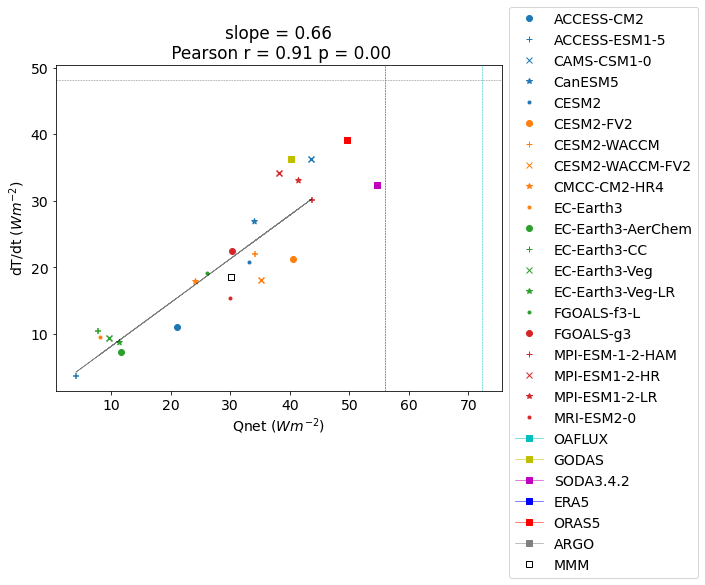

In [240]:
#S5
#WTIO QNET - DT jan-Mar
TA = test_fn3(models, OBS,  'Q', 'dTdt', -10,10,50,70, [1,2,3])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('Qnet ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_5.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF5.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


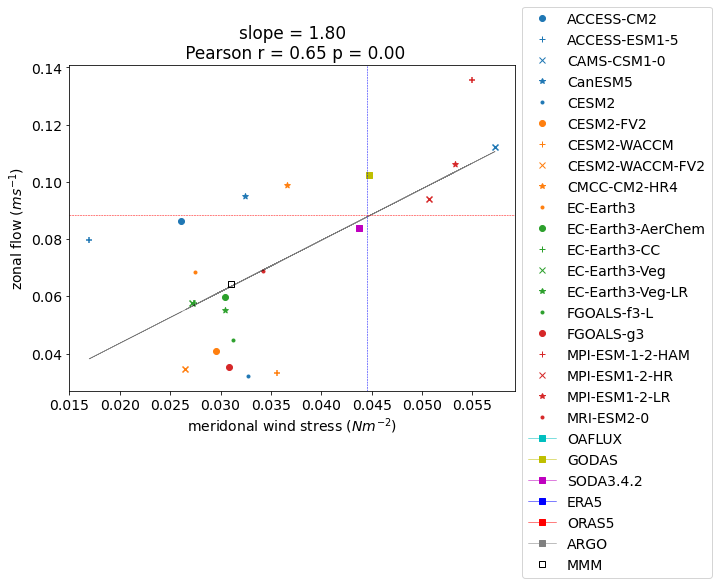

In [241]:
#s6
#WTIO vwind ucur May-June
TA = test_fn3(models, OBS,  'vw', 'ucur', -10,10,50,70, [5,6])
plt.ylabel('zonal flow ($ms^{-1}$)')
plt.xlabel('meridonal wind stress ($Nm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_6.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF6.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

In [242]:
#s7 TC depth

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


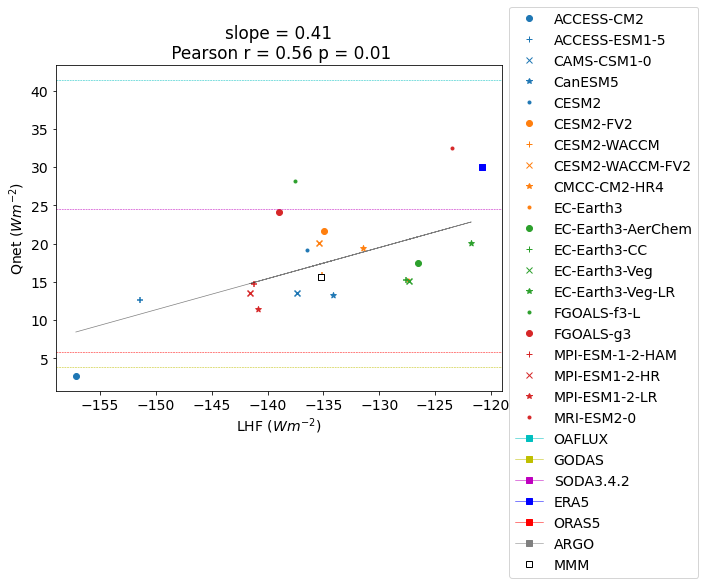

In [243]:
#S8 
#SETIO LHF Q annual
TA = test_fn3(models, OBS,  'lhf', 'Q', -10,0,90,110, [1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Qnet ($Wm^{-2}$)')
plt.xlabel('LHF ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_8.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF8.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


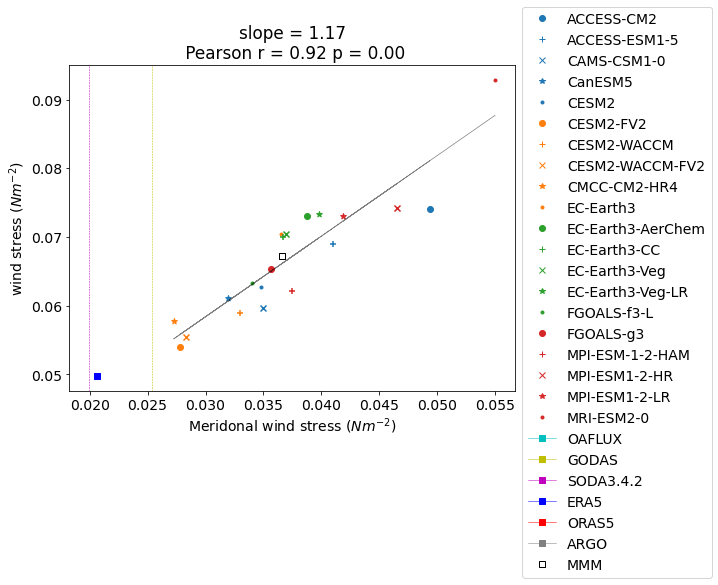

In [244]:
#S9
#SETIO  June/July v wind wind
TA = test_fn3(models, OBS,  'vw', 'wspd', -10,0,90,110, [6,7])
plt.ylabel('wind stress ($Nm^{-2}$)')
plt.xlabel('Meridonal wind stress ($Nm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_9.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_9.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


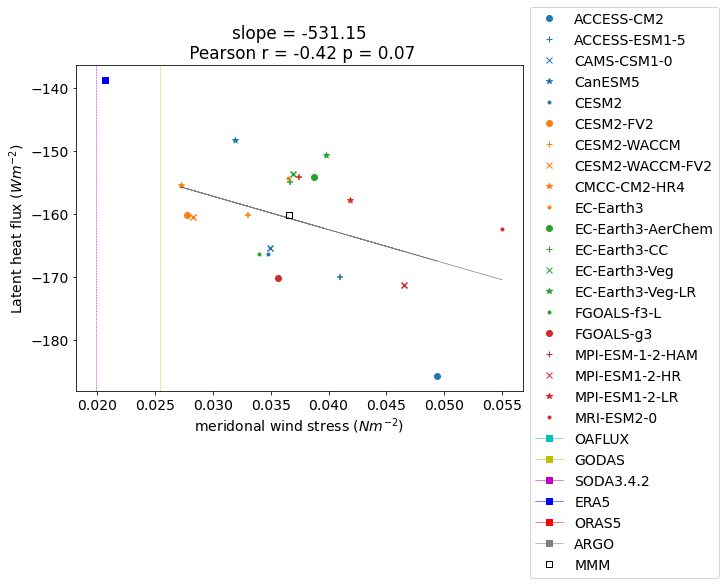

In [245]:
#s10
#SETIO vwind lhf june-july
TA = test_fn3(models, OBS,  'vw', 'lhf', -10,0,90,110, [6,7])
plt.ylabel('Latent heat flux ($Wm^{-2}$)')
plt.xlabel('meridonal wind stress ($Nm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_10.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_10.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


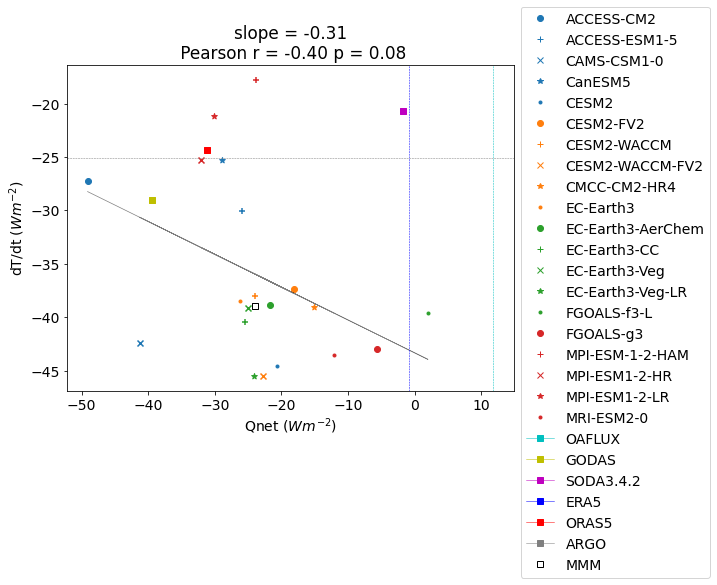

In [246]:
#s11
#SETIO Q dt june-sep
TA = test_fn3(models, OBS,  'Q', 'dTdt', -10,0,90,110, [6,7,8,9])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('Qnet ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_11.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_11.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


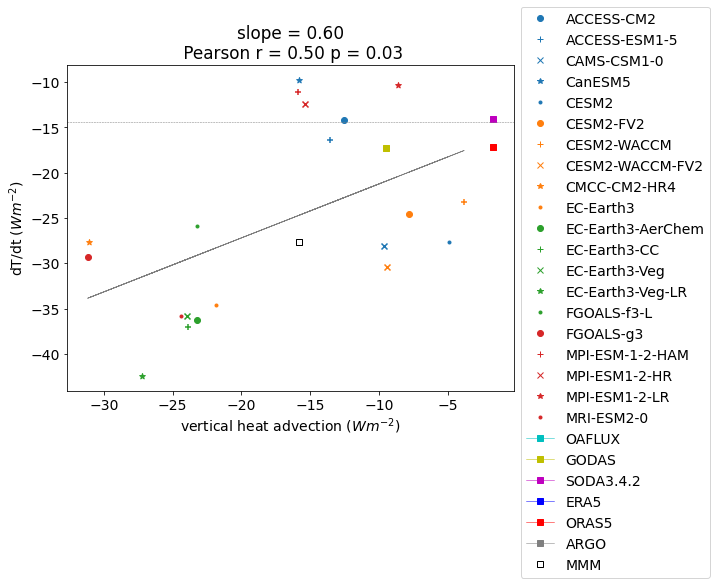

In [247]:
#S12
#smaller SETIO 100E, Q dt Jul-Oct
TA = test_fn3(models, OBS,  'wa', 'dTdt', -10,0,90,100, [7,8,9,10])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('vertical heat advection ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_12.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_12.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


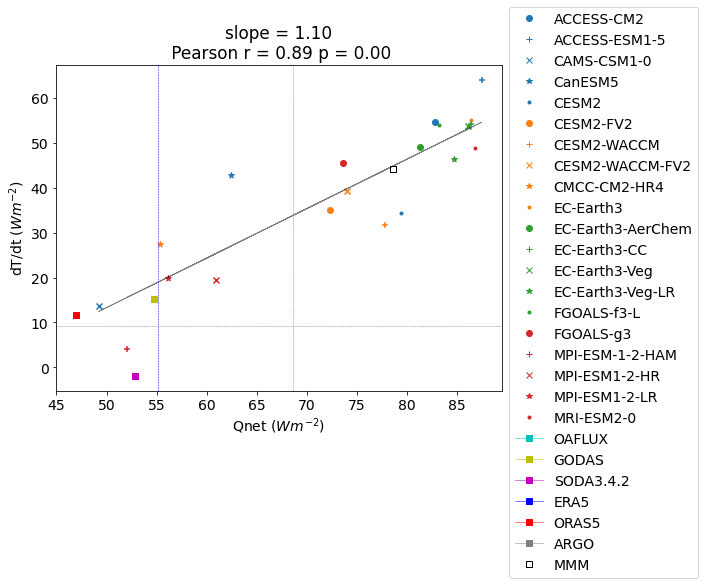

In [248]:
#s13
#AS Ap-June Q dt
TA = test_fn3(models, OBS,  'Q', 'dTdt', 10,20,50,70, [4,5,6])
plt.ylabel('dT/dt ($Wm^{-2}$)')
plt.xlabel('Qnet ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_13.eps', 
            pad_inches = 1, bbox_inches = 'tight')
plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_13.png', 
            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

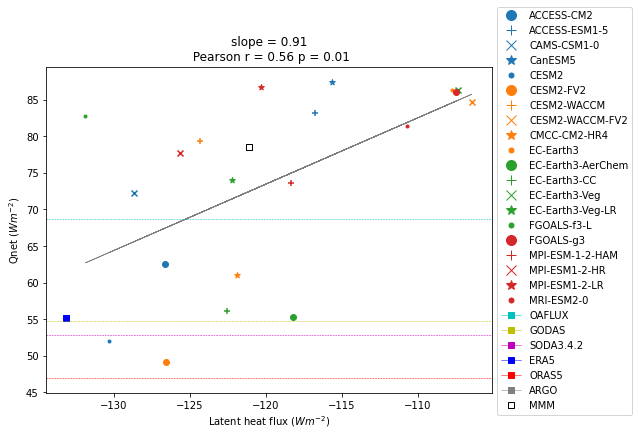

In [54]:
#s14
#AS Ap-June Q dt
TA = test_fn3(models, OBS,  'lhf', 'Q', 10,20,50,70, [4,5,6])
plt.ylabel('Qnet ($Wm^{-2}$)')
plt.xlabel('Latent heat flux ($Wm^{-2}$)')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_14.eps', 
#            pad_inches = 1, bbox_inches = 'tight')
#plt.savefig('/home/z5113258/Documents/figures/Paper_23-01-30/SF_14.png', 
#            pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')

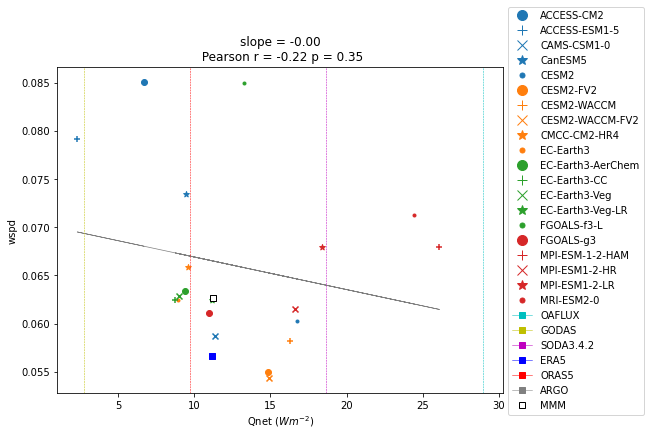

In [74]:
#BOB tests
TA = test_fn3(models, OBS,  'Q', 'wspd', 10,20,80,100, [1,2,3,4,5,6,7,8,12,9,10,11])
plt.xlabel('Qnet ($Wm^{-2}$)')
plt.ylabel('wspd')
plt.legend(handles, labels, bbox_to_anchor=(1, 1.2), loc='upper left')

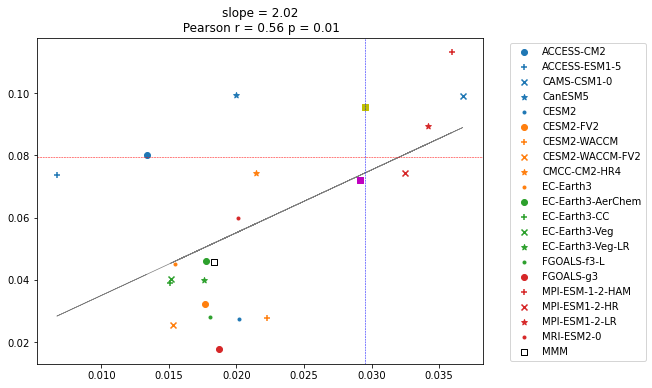

In [29]:
TA = test_fn3(models, OBS,  'vw', 'ucur', -10,10,50,70, [4,5,6])


In [ ]:
plt.rcParams['font.size'] = 14
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()
variables = ['Q', 'dTdt','wspd', 'lhf','ua', 'dTdt','wspd', 'ua']
months = [[7,8,9,10,11,12,1,2,3,4],[12,1,2,3,4],[5,6],[5,6]]
for i in range(4):
    v1 = variables[i*2]
    v2 = variables[i*2 + 1]
    month = months[i]
    test_fn5(models,OBS, i, v1, v2, -10,10,50,70, month)
    axs[i].set_xlabel(var_titles[v1])
    axs[i].set_ylabel(var_titles[v2])
plt.tight_layout()

In [40]:
def get_model_DS(MODS, lat, lat_r, lon, lon_r):
    for i, model in enumerate(MODS.keys()):
        HB = MODS[model]
        T= get_region((HB['dTdt']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        U=get_region((HB['ua']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        V=get_region((HB['va']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        W=get_region((HB['wa']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        Q=get_region((HB['Q']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        resid = get_region((HB['res']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        SST = get_region((HB['SST']), lat, lat_r, lon, lon_r)

        T = T.assign_coords({"model":model})
        U = U.assign_coords({"model":model})
        V = V.assign_coords({"model":model})
        W = W.assign_coords({"model":model})
        Q = Q.assign_coords({"model":model})
        resid = resid.assign_coords({"model":model})
        SST = SST.assign_coords({"model":model})
        
        #now turn all these variables into an array
        if i == 0:
            TM = T
            UM = U
            VM = V
            WM = W
            QM = Q
            RM = resid
            SSTM = SST
        else:
            TM = xr.concat([TM, T], dim = 'model')
            UM = xr.concat([UM, U], dim = 'model')
            VM = xr.concat([VM, V], dim = 'model')
            WM = xr.concat([WM, W], dim = 'model')
            QM = xr.concat([QM, Q], dim = 'model')
            RM = xr.concat([RM, resid], dim = 'model')    
            SSTM = xr.concat([SSTM, SST], dim = 'model')    
    DS = xr.Dataset(data_vars=dict(
            TM=(["model", "month"], TM),
            UM=(["model", "month"], UM),
            VM=(["model", "month"], VM),
            WM=(["model", "month"], WM),
            QM=(["model", "month"], QM),
            SSTM=(["model", "month"], SSTM),
            RM=(["model", "month"], RM)),
        coords=dict(
            month=(TM.month),
            model=(TM.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    return DS

In [31]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],# reduce along 'model'
                        )
    return slope

In [44]:
def plot_regress_corr_dt(DS):
    #lag SST
    SST_lag = DS['TM']#.roll(month=1).assign_coords(month=DS['SSTM'].month)    
    tu = regress(DS['UM'], SST_lag).assign_coords({"var":1})
    tv = regress(DS['VM'], SST_lag).assign_coords({"var":2})
    tw = regress(DS['WM'], SST_lag).assign_coords({"var":3})
    tq = regress(DS['QM'], SST_lag).assign_coords({"var":4})
    tr = regress(DS['RM'], SST_lag).assign_coords({"var":5})
    tt = regress(DS['TM'], SST_lag).assign_coords({"var":6})
    
    ru = xs.pearson_r(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    rv = xs.pearson_r(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    rw = xs.pearson_r(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    rq = xs.pearson_r(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    rr = xs.pearson_r(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    rt = xs.pearson_r(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})
    pu = xs.pearson_r_p_value(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    pv = xs.pearson_r_p_value(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    pw = xs.pearson_r_p_value(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    pq = xs.pearson_r_p_value(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    pr = xs.pearson_r_p_value(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    pt = xs.pearson_r_p_value(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})

    
    
    DA1 = xr.concat([tu, tv, tw, tq, tr], dim = "var")
    DA2 = xr.concat([ru, rv, rw, rq, rr], dim = "var")
    DA3 = xr.concat([pu, pv, pw, pq, pr], dim = "var")
    plt.figure(figsize=(10,4))
    DA1.plot.imshow()#plto colors where significant
    plt.yticks([1,2,3,4,5],['$Advection_{u}$: $dT/dt$','$Advection_{v}$: $dT/dt$',
                            '$Advection_{w}$: $dT/dt$','$Qnet$: $dT/dt$','$resid$: $dT/dt$',])#plot variables corerlated
    plt.ylabel(' ')
    plt.title("Intermodel regression coeficient by month \n pearson correlation annotated significant in darker shade")
    for i in range(0,12):
        for j in range(1,6):
            plt.text(i+0.66,j,f'{DA2.sel(month = i+1).sel(var = j).values:.2f}', 
                     color = 'k' if DA3.sel(month = i+1).sel(var = j).values < 0.05 else 'gray')
                  
    return

In [41]:
ds_BOB = get_model_DS(models, 10,20,80,100)

/home/z5113258/anaconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:281: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))


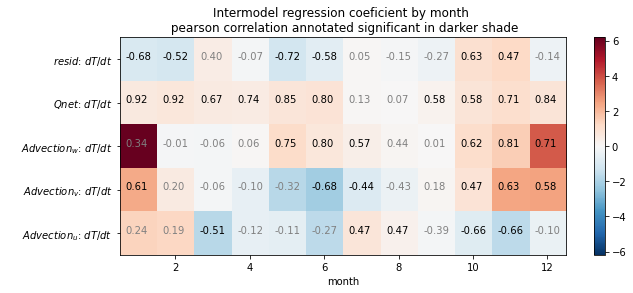

In [45]:
plot_regress_corr_dt(ds_BOB)

Text(0.5, 0, 'wind stress ($Nm^{-2}$)')

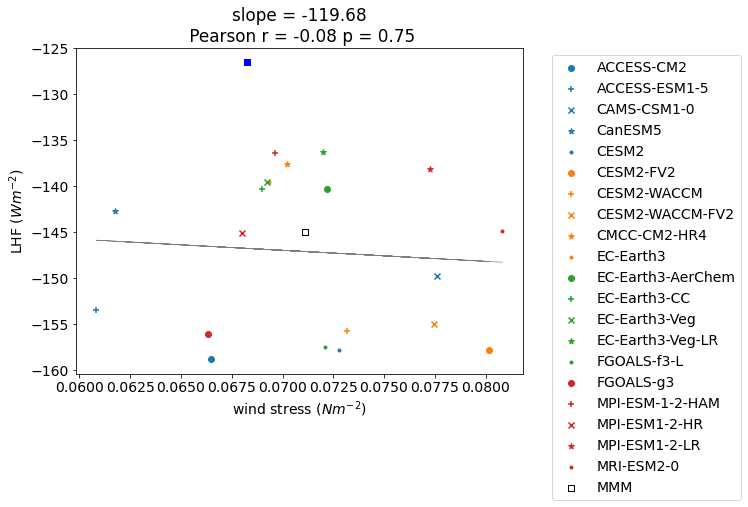

In [204]:
TA = test_fn3(models, OBS,  'wspd', 'lhf', -10,10,50,70, [6,7,8,9,10,11])
plt.ylabel('LHF ($Wm^{-2}$)')
#plt.xlabel('Qnet ($Wm^{-2}$)')
plt.xlabel('wind stress ($Nm^{-2}$)')


#plt.ylabel('vert adv ($W*m^{-2}$)')
#plt.ylabel('Qnet ($W*m^{-2}$)')
#plt.ylabel('U advection ($Wm^{-2}$)')
#plt.ylabel('U current ($ms^{-1}$)')

#plt.ylabel('$dT/dt$ ($W*m^{-2}$)')

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


Text(0, 0.5, 'W advection ($Wm^{-2}$)')

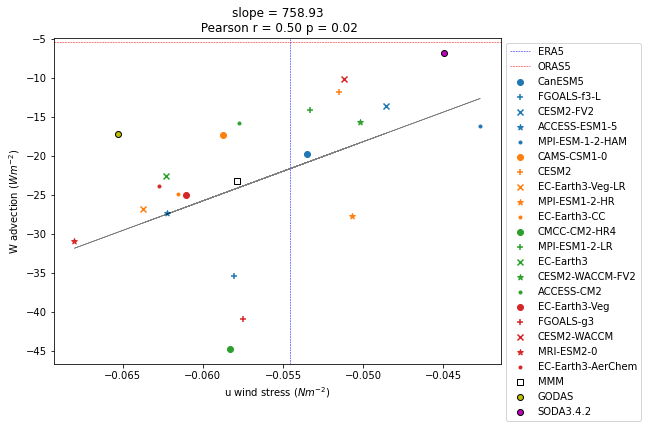

In [119]:
TA = test_fn3(models, OBS,  'uw', 'wa', -10,0,90,110, [7,8,9])
#plt.ylabel('LHF ($Wm^{-2}$)')
plt.xlabel('u wind stress ($Nm^{-2}$)')
#plt.xlabel('Qnet ($Wm^{-2}$)')
#plt.ylabel('wind stress ($Nm^{-2}$)')


#plt.ylabel('vert adv ($W*m^{-2}$)')
#plt.ylabel('Qnet ($W*m^{-2}$)')
plt.ylabel('W advection ($Wm^{-2}$)')
#plt.ylabel('U current ($ms^{-1}$)')

#plt.ylabel('$dT/dt$ ($W*m^{-2}$)')

'int' object has no attribute 'sel' one doesnt exist
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


Text(0, 0.5, 'Qnet ($Wm^{-2}$)')

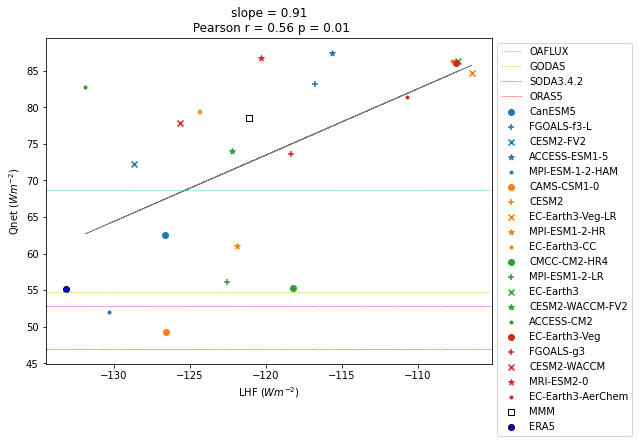

In [133]:
TA = test_fn3(models, OBS,  'lhf', 'Q', 10,20,50,70, [4,5,6])
plt.xlabel('LHF ($Wm^{-2}$)')
#plt.xlabel('u wind stress ($Nm^{-2}$)')
plt.ylabel('Qnet ($Wm^{-2}$)')
#plt.ylabel('wind stress ($Nm^{-2}$)')
#plt.ylabel('$dT/dt$ ($W*m^{-2}$)')

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


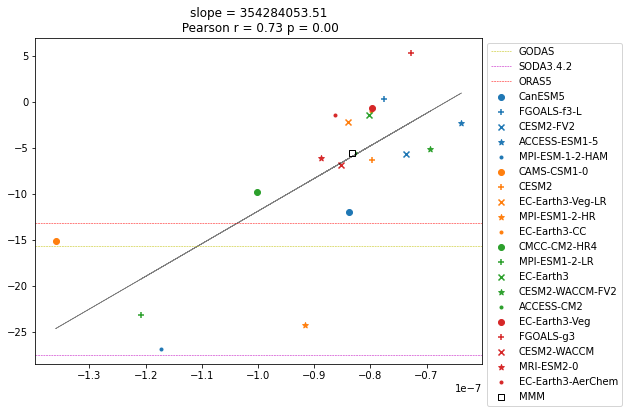

In [72]:
TA = test_fn3(models, OBS,  'wsc', 'ua', -10,10,50,70, [5,6])


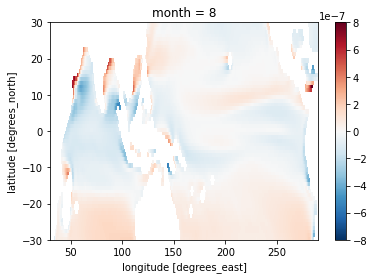

In [63]:
models['ACCESS-CM2']['wsc'][7].plot()

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


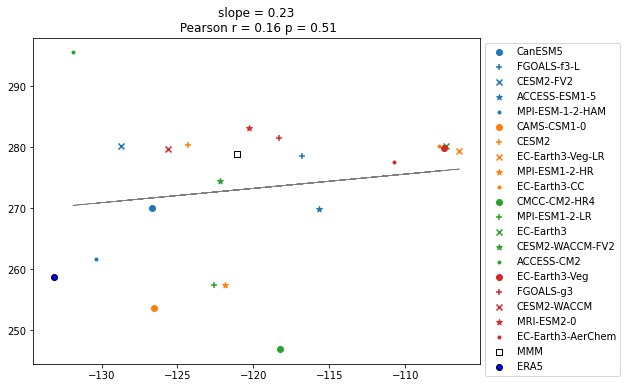

In [40]:
TA = test_fn3(models, OBS,  'lhf', 'sw', 10,20,50,70, [4,5,6])


In [151]:
#ekman upwelling contribution
def coriolis_param(lat):
    day = (24*60*60)-(4*60)# this is 23hrs 56mins
    om = (2*np.pi)/day
    f = 2*om*np.sin(lat * np.pi / 180)
    return f
def ekman(taux, tauy):
    rho = 1026#kgm^-3
    f = coriolis_param(taux.lat)
    dtydx = tauy.differentiate('lon') / (110e3 * np.cos(tauy.lat * np.pi / 180))
    dtxdy = taux.differentiate('lat') / (110e3)
    ek = (1/(rho*f))*(dtydx-dtxdy)
    return ek

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO
'int' object has no attribute 'sel' one doe

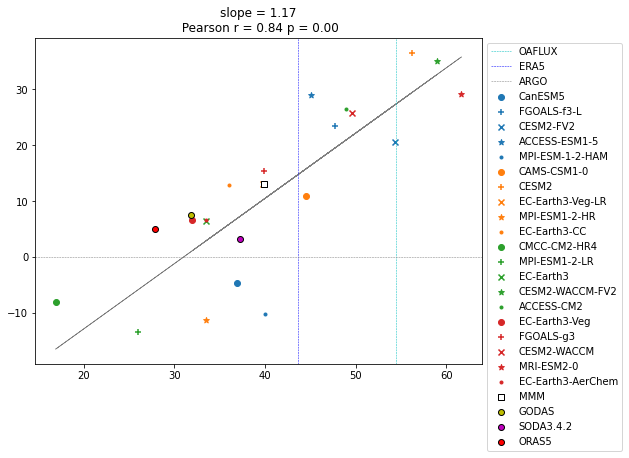

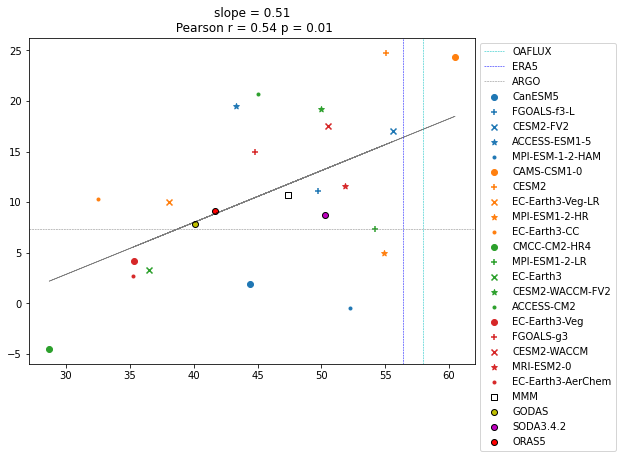

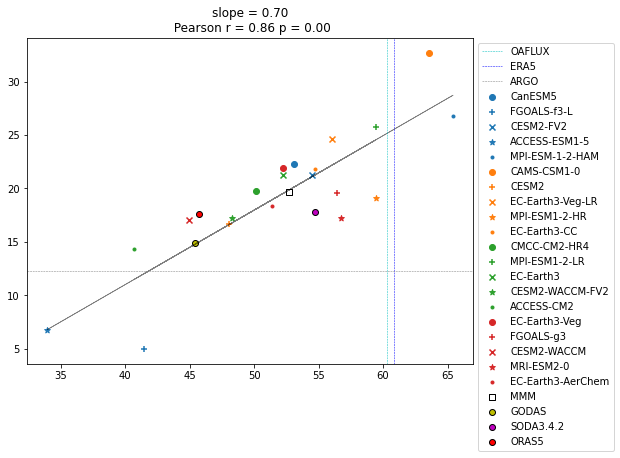

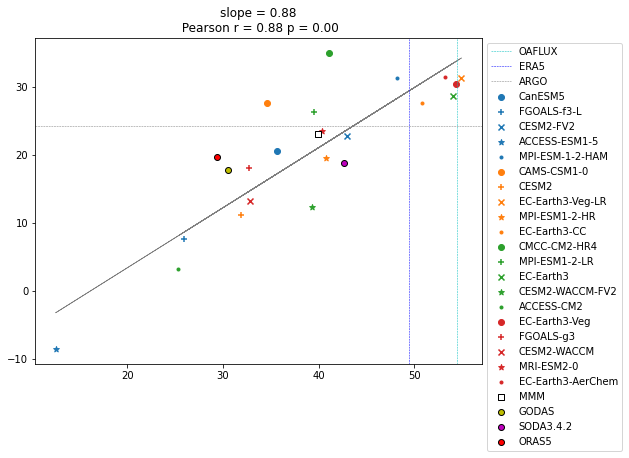

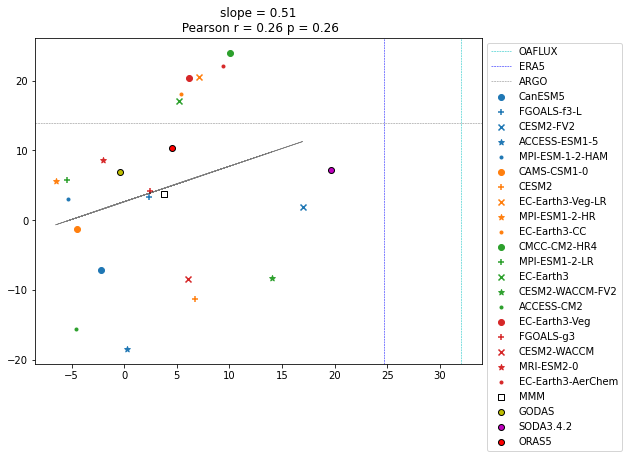

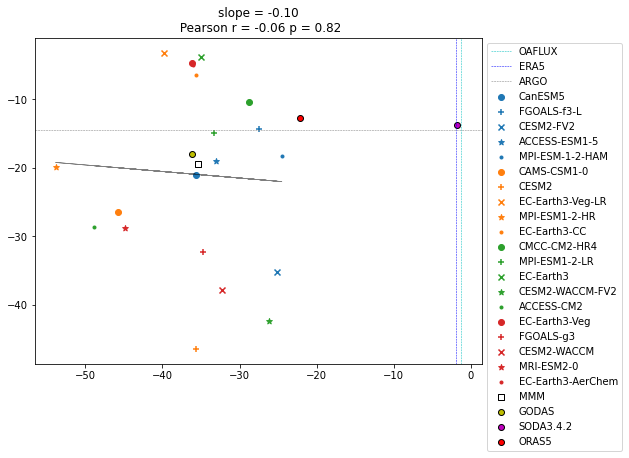

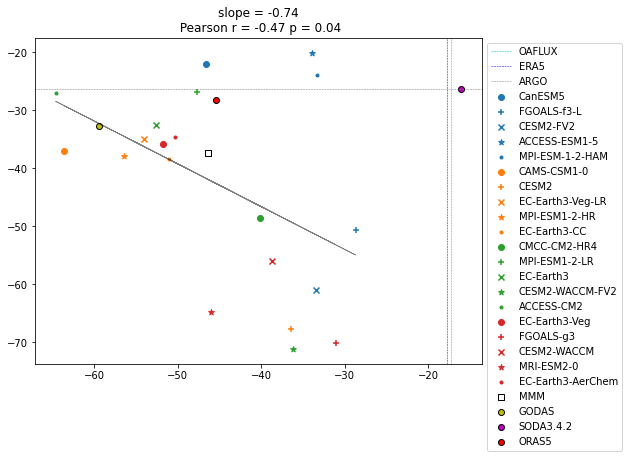

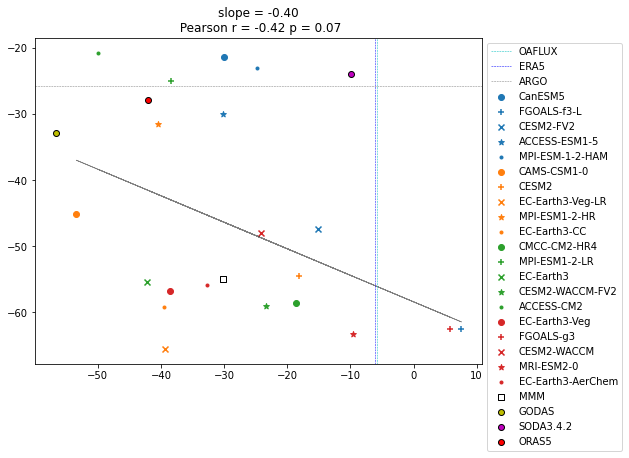

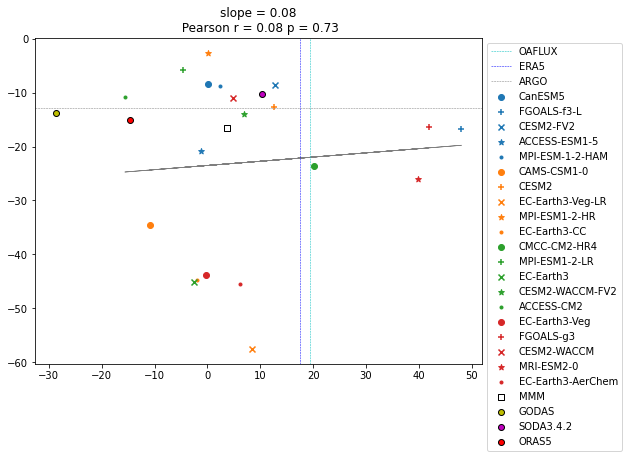

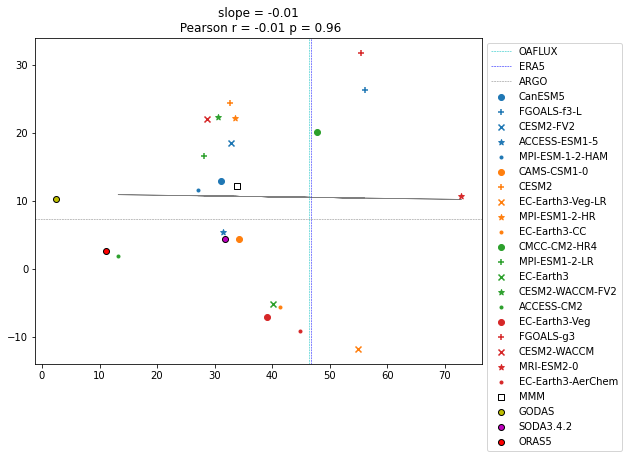

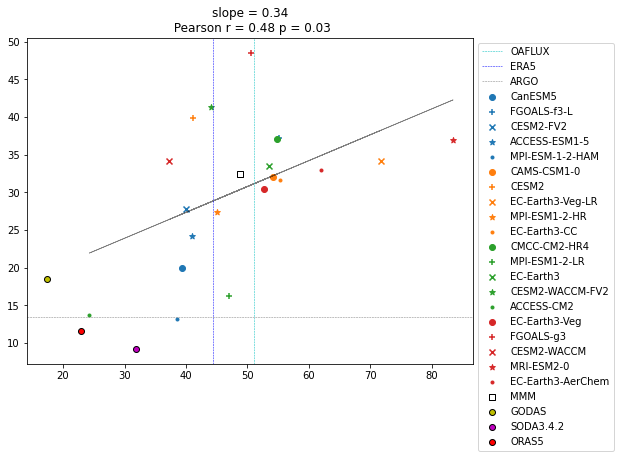

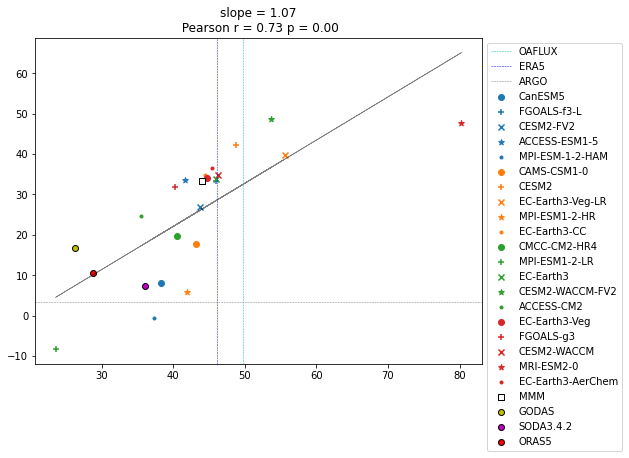

In [99]:
for i in range(0,12,1):
    TA = test_fn3(models, OBS,  'Q', 'dTdt', -10,0,90,100, [1+i])


'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v2 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


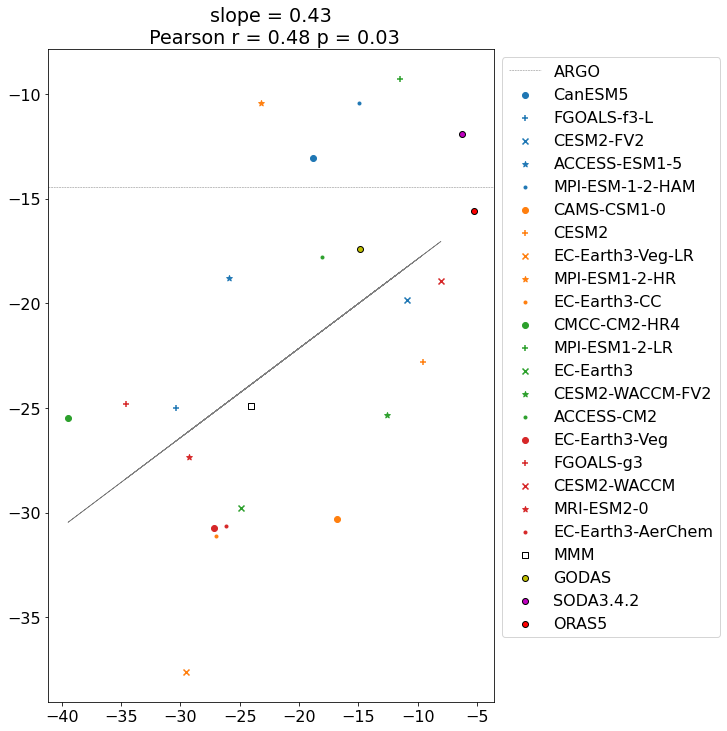

In [564]:
TA = test_fn3(models, OBS,  'wa', 'dTdt', -10,0,90,110, [7,8,9,10])


In [32]:
models['ACCESS-CM2'].keys()

dict_keys(['dTdt', 'ua', 'va', 'wa', 'lw', 'sw', 'lhf', 'shf', 'SST', 'dtdx', 'dtdy', 'dtdz', 'wcur', 'vcur', 'ucur', 'uw', 'vw', 'wspd', 'Q', 'res'])

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


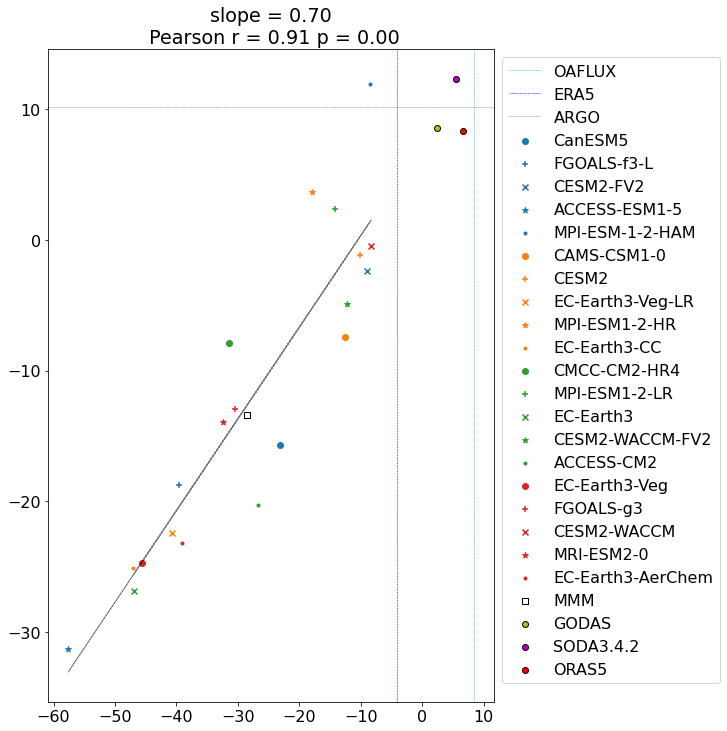

In [588]:
TA = test_fn3(models, OBS,  'Q', 'dTdt', 10,20,50,70, [10,11,12,1,2,3])


In [458]:
TA.plot.scatter(x = 'wspd', y = 'lhf', col = 'month', col_wrap = 4)

ValueError: x must be one of (dTdt, model, wa)

In [109]:
r,p = test_fn2(models, OBS,  'Q', 'dTdt', -10,0,90,110, 7)

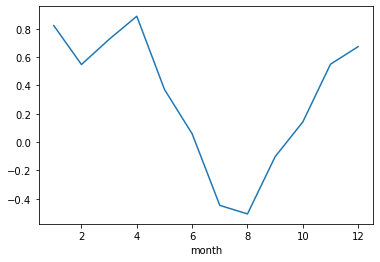

In [110]:
r.plot()

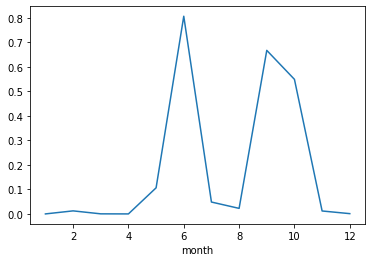

In [111]:
p.plot()

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


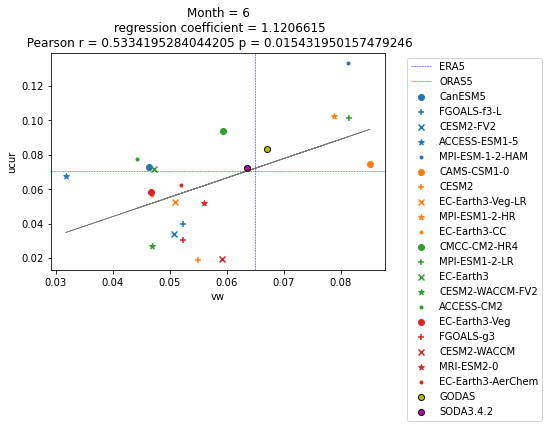

In [121]:
test_fn(models, OBS, 'vw', 'ucur', -10,10,50,70, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


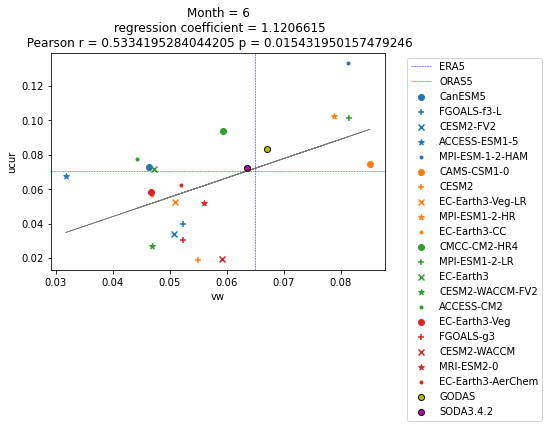

In [21]:
test_fn(models, OBS, 'vw', 'ucur', -10,10,50,70, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


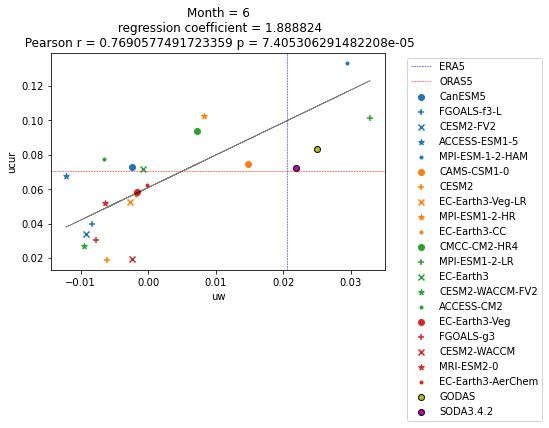

In [22]:
test_fn(models, OBS, 'uw', 'ucur', -10,10,50,70, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v2 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


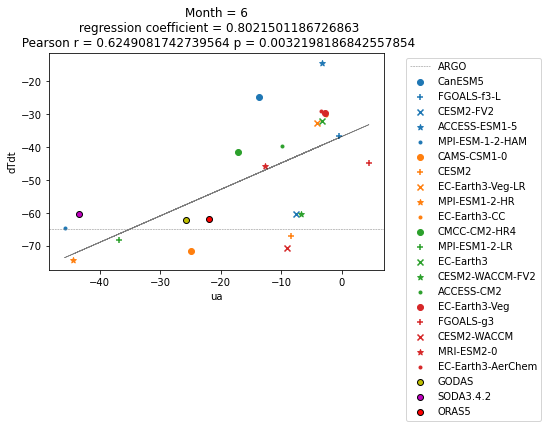

In [125]:
test_fn(models, OBS, 'ua', 'dTdt', -10,10,50,70, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


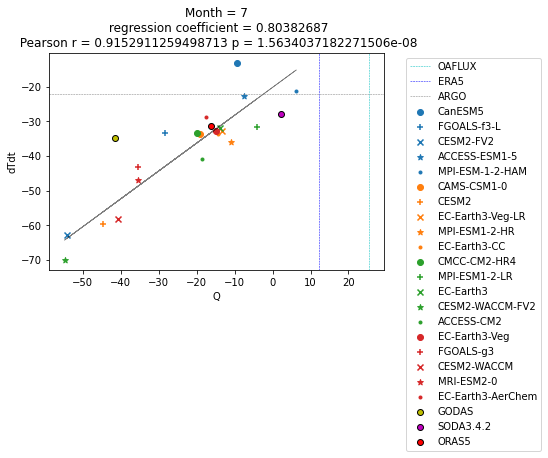

In [133]:
test_fn(models, OBS, 'Q', 'dTdt', -10,10,50,70, 6)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exi

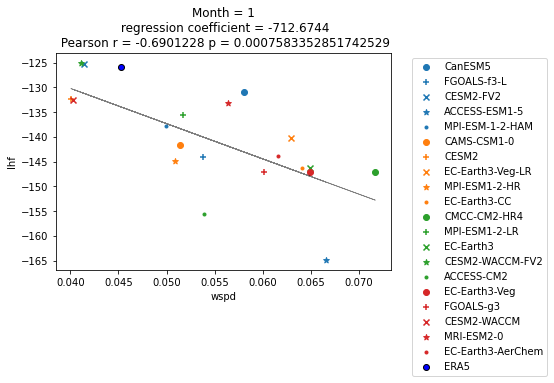

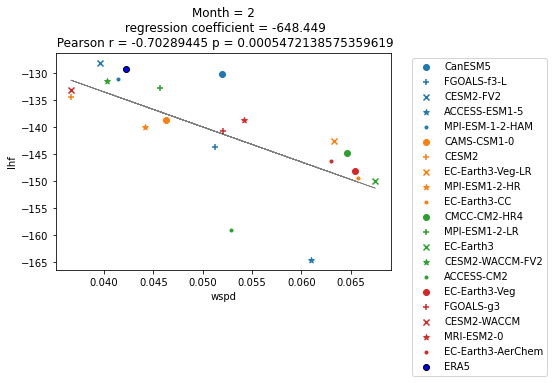

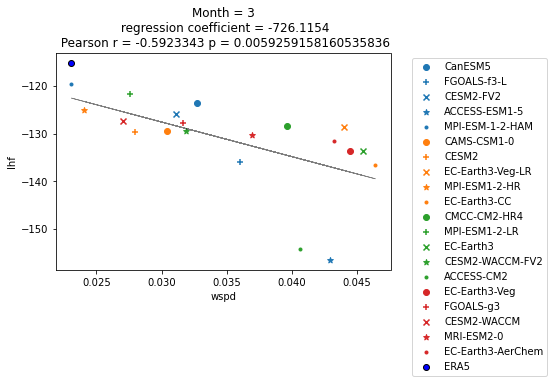

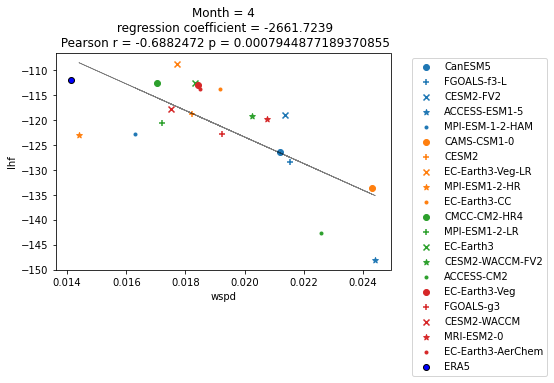

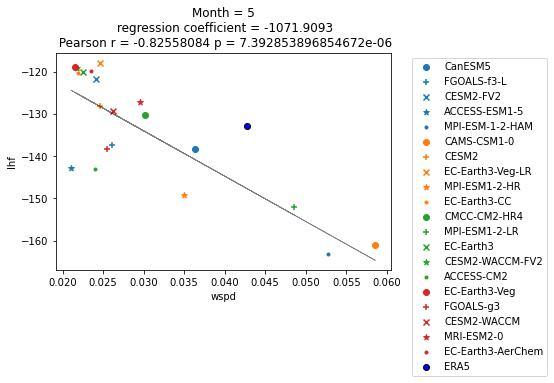

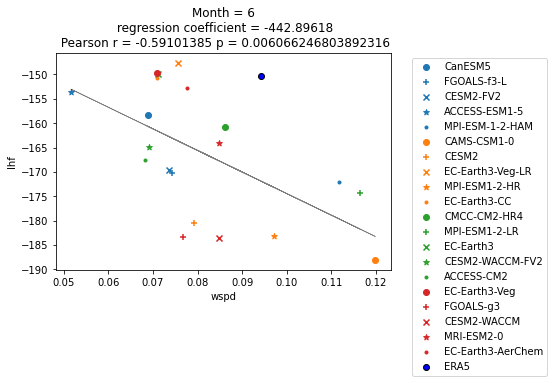

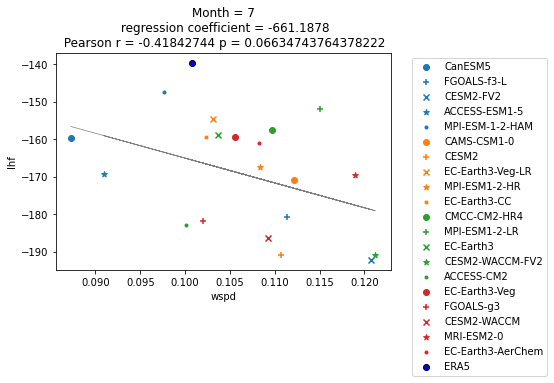

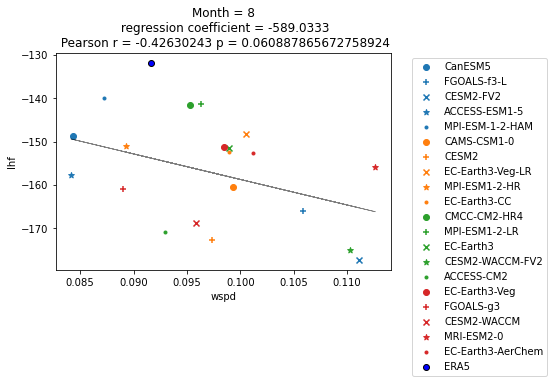

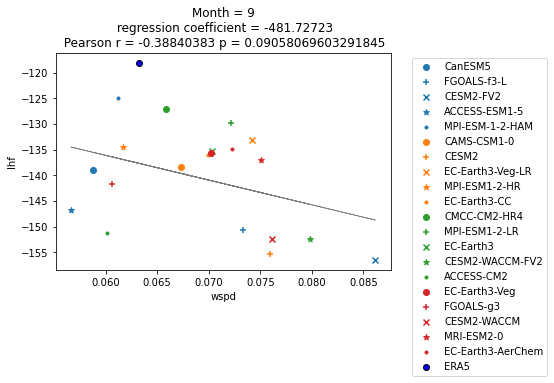

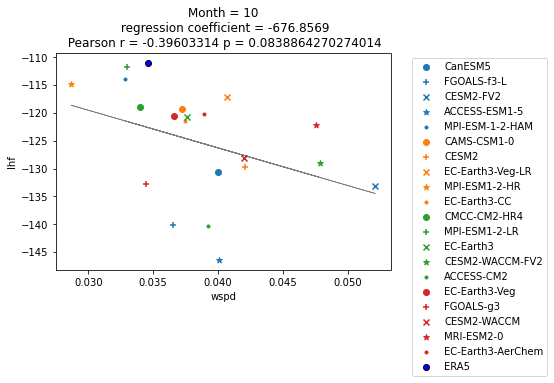

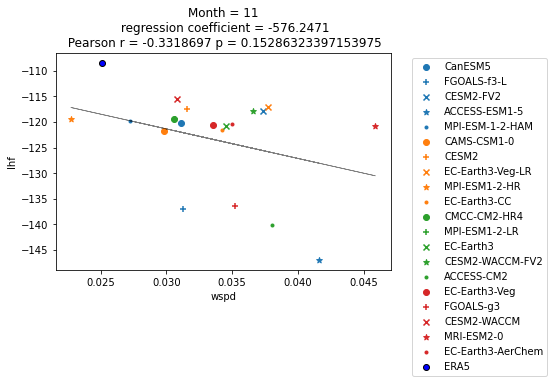

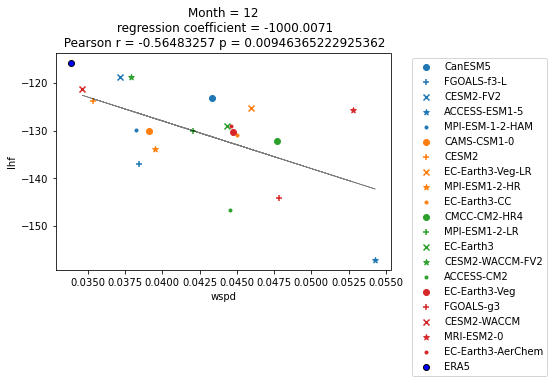

In [257]:
for i in range (0,12):
    test_fn(models, OBS, 'wspd', 'lhf', -10,10,50,70, i)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO
'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' o

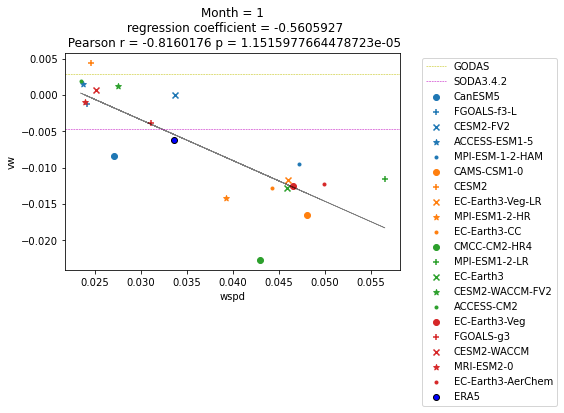

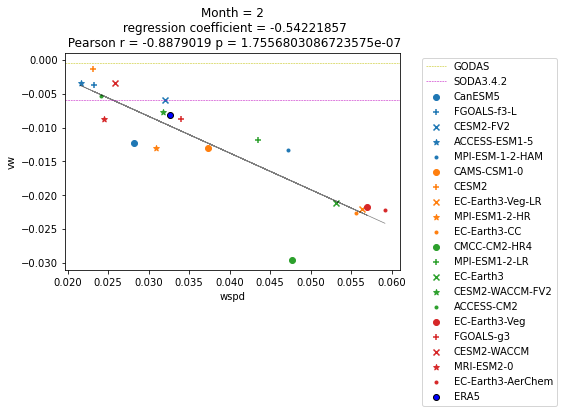

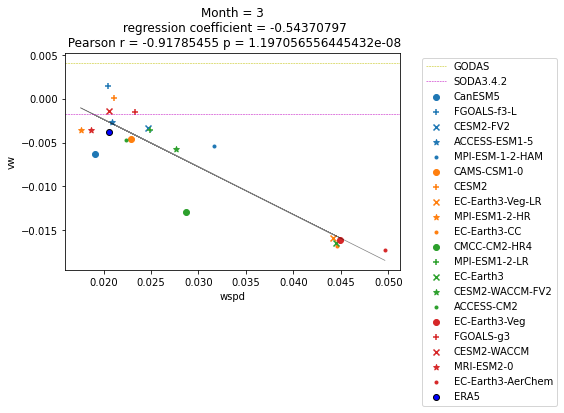

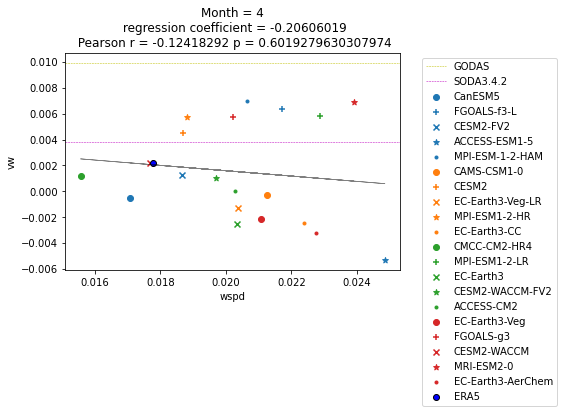

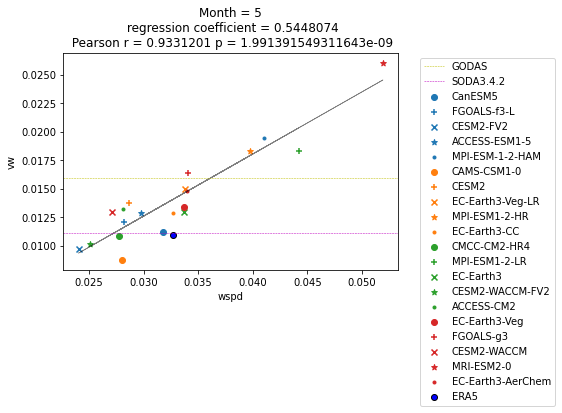

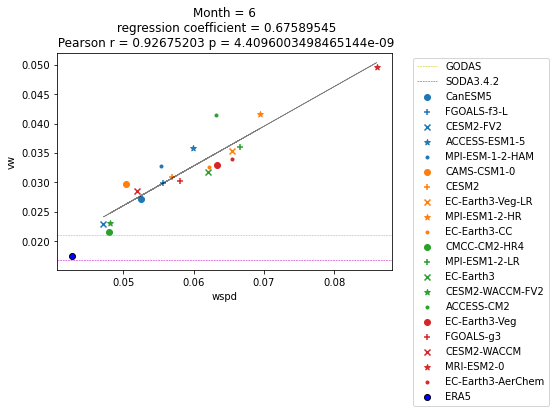

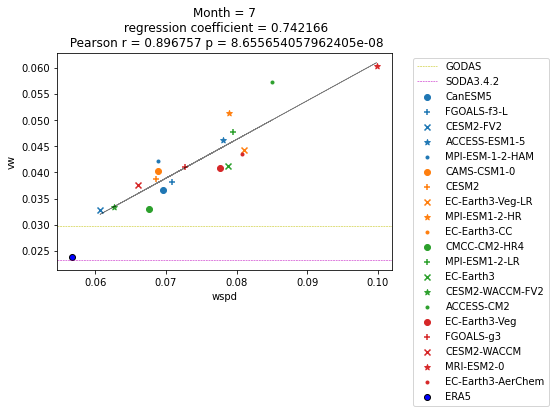

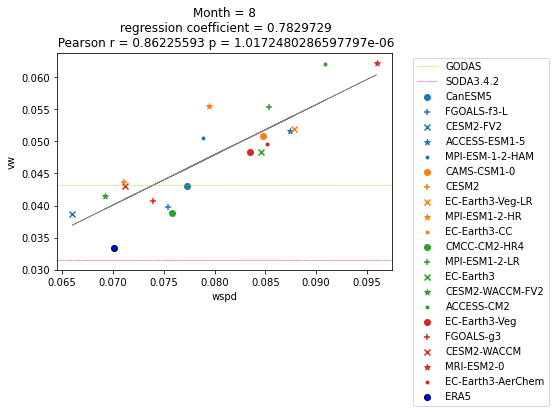

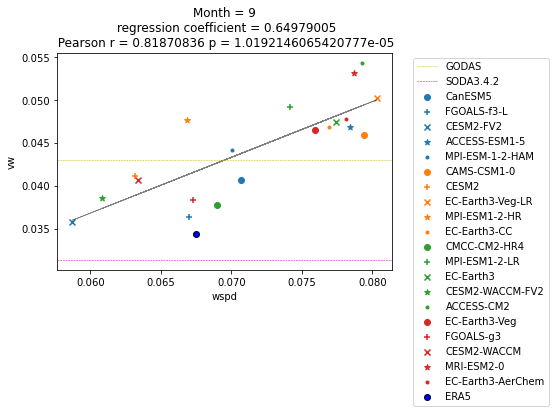

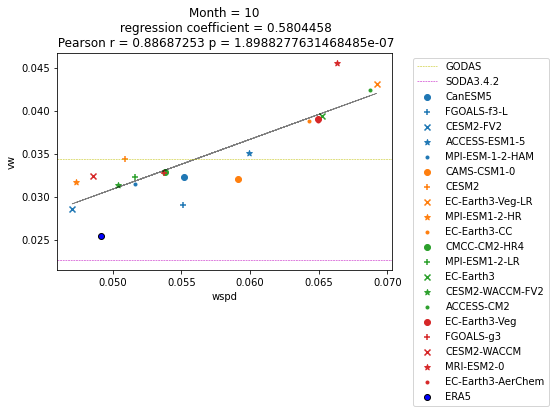

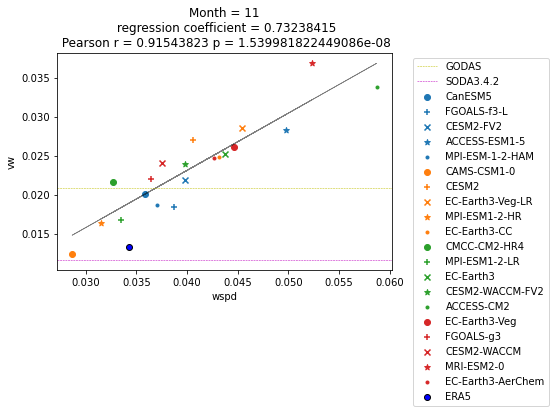

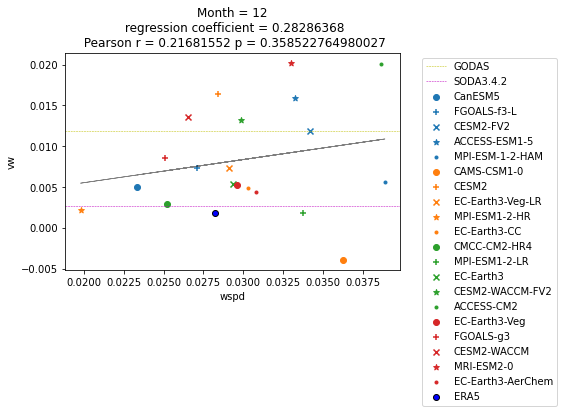

In [256]:
for i in range (0,12):
    test_fn(models, OBS, 'wspd', 'vw', -10,0,90,110, i)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


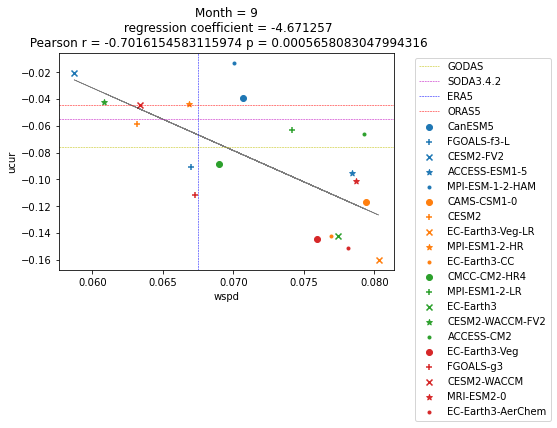

In [148]:
#SETIO
test_fn(models, OBS,  'wspd', 'ucur', -10,0,90,110, 8)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v2 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


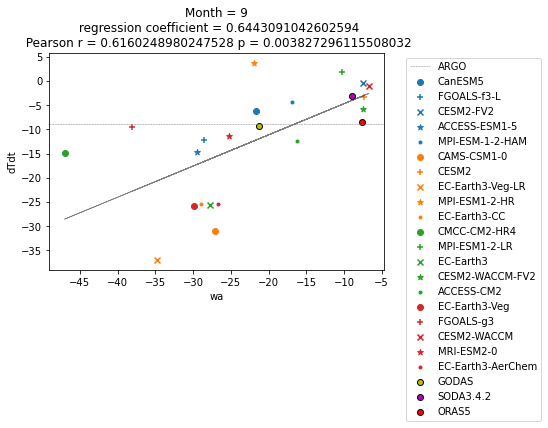

In [180]:
test_fn(models, OBS,  'wa', 'dTdt', -10,0,90,110, 8)

'int' object has no attribute 'sel' one doesnt exist
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


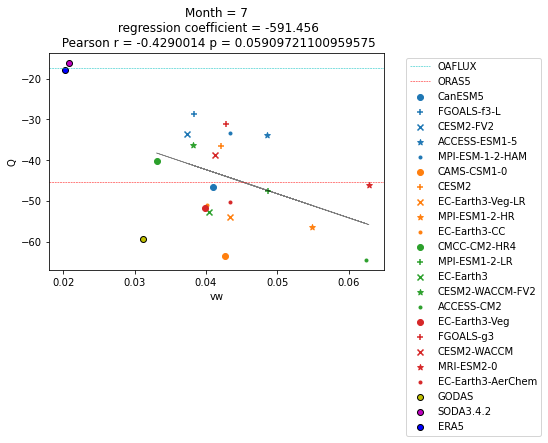

In [166]:
test_fn(models, OBS,  'vw', 'Q', -10,0,90,100, 6)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


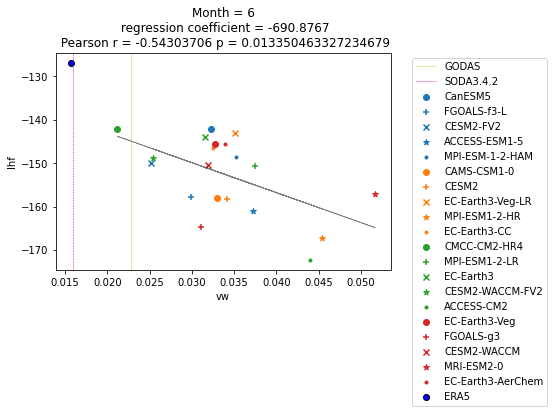

In [430]:
test_fn(models, OBS,  'vw', 'lhf', -10,0,90,100, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


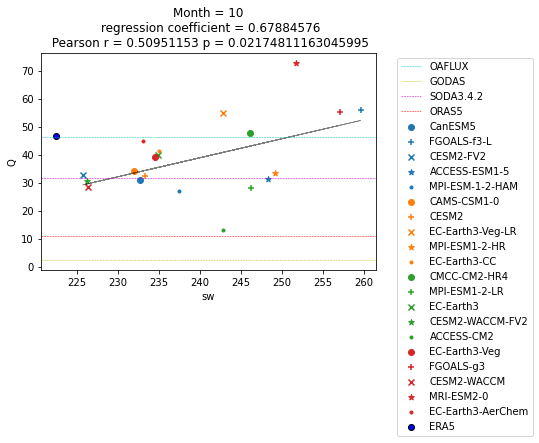

In [450]:
test_fn(models, OBS,  'sw', 'Q', -10,0,90,100, 9)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


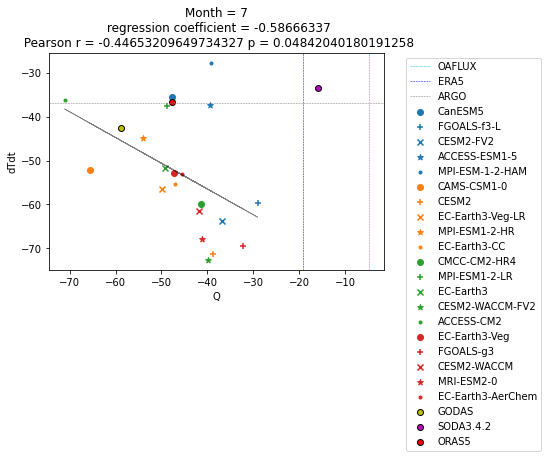

In [136]:
test_fn(models, OBS,  'Q', 'dTdt', -10,0,90,110, 6)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v2 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


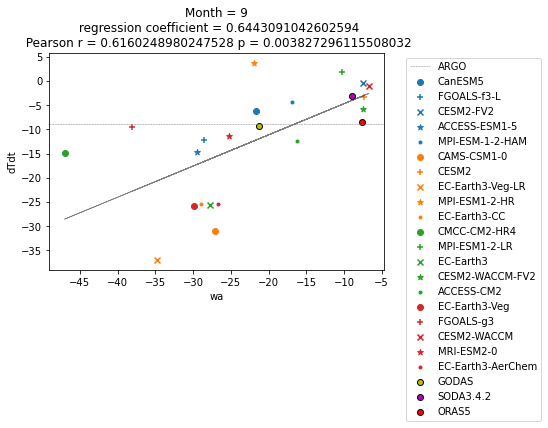

In [176]:
test_fn(models, OBS,  'wa', 'dTdt', -10,0,90,110, 8)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


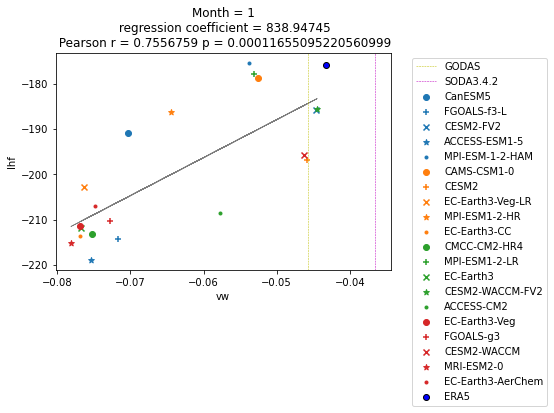

In [167]:
#ARABIAn SEA
test_fn(models, OBS, 'vw', 'lhf', 10,20,50,70, 0)

'int' object has no attribute 'sel' one doesnt exist
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


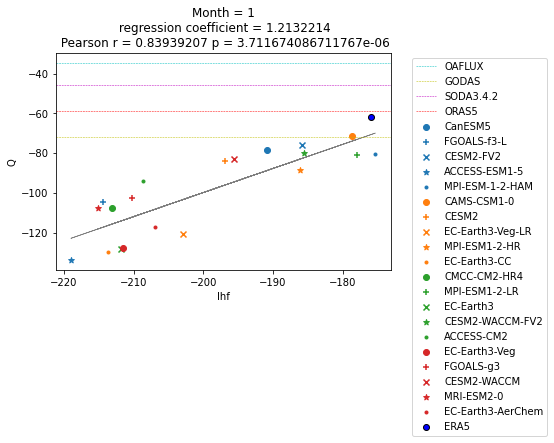

In [66]:
test_fn(models, OBS, 'lhf', 'Q', 10,20,50,70, 0)

'int' object has no attribute 'sel' one doesnt exist
no data v2 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


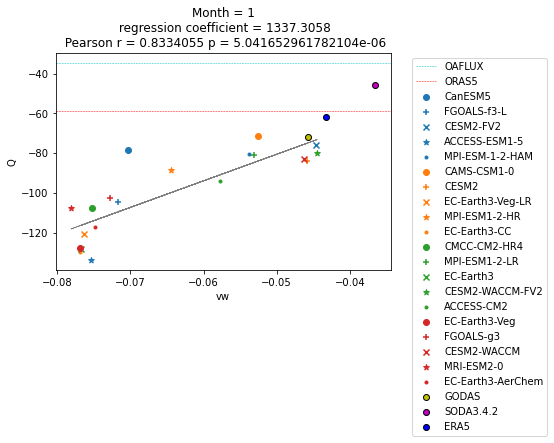

In [343]:
test_fn(models, OBS, 'vw', 'Q', 10,20,50,70, 0)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v1 GODAS
no data v2 GODAS
no data v1 SODA3.4.2
no data v2 SODA3.4.2
'int' object has no attribute 'sel' one doesnt exist
no data v1 ERA5
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v2 ARGO


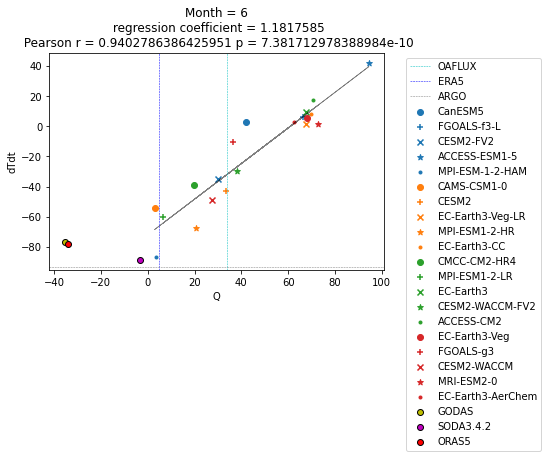

In [173]:
test_fn(models, OBS, 'Q', 'dTdt', 10,20,50,70, 5)

'int' object has no attribute 'sel' one doesnt exist
no data v1 OAFLUX
no data v2 OAFLUX
'int' object has no attribute 'sel' one doesnt exist
no data v1 GODAS
no data v2 GODAS
'int' object has no attribute 'sel' one doesnt exist
no data v1 SODA3.4.2
no data v2 SODA3.4.2
no data v1 ERA5
no data v2 ERA5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ORAS5
no data v2 ORAS5
'int' object has no attribute 'sel' one doesnt exist
no data v1 ARGO
no data v2 ARGO


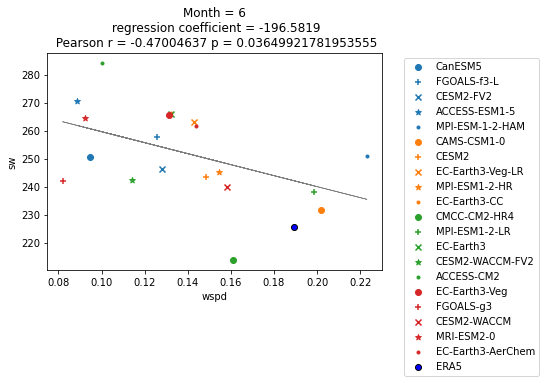

In [168]:
test_fn(models, OBS, 'wspd', 'sw', 10,20,50,70, 5)

In [331]:
OBS['ERA5']['Q']

<xarray.DataArray (month: 12, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-41.859337, -41.89403 , -41.927628, ..., -41.7547  ,
         -41.791145, -41.826992],
        [-40.107845, -40.05742 , -40.034958, ..., -40.23363 ,
         -40.208553, -40.159626],
        [-39.40448 , -39.374794, -39.3472  , ..., -39.48848 ,
         -39.459824, -39.43158 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-35.32972 , -35.264706, -35.198723, ..., -35.389923,
         -35.380016, -35.368053],
        [-34.491394, -34.41864 , -34.37375 , ..., -34.6595  ,
         -34.635628, -34.56422 ],
        [-34.35876 , -34.29975 , -34.240265, ..., -34.536278,
         -34.47669 , -34.417618]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-40.19797 , -40.14164 , -40.0833  , ..., -40.192806,
         -40.207104, -40.22127 ],
        [-38.967117, -38.913044, -38.894817, ..., -39.087444,
         -39.076157, -39.02111 ],
        [-38.81211 , -38.771797, -38.73519 , ..., -38.921566,
         -38.885246, -38.84753 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [332]:
DS_WTIO_vwuc = get_model_DS(models, 'vw', 'Q', 10,20,50,70)

In [335]:
DS_WTIO_vwuc['Q']

<xarray.DataArray 'Q' (model: 20, month: 12)>
array([[ -78.66574   ,  -32.614445  ,   28.88148   ,   70.67353   ,
          74.66143   ,   42.077965  ,   12.767908  ,   37.657505  ,
          66.67264   ,   43.120277  ,  -23.959337  ,  -75.93973   ],
       [-104.52349   ,  -39.13247   ,   36.32771   ,   87.72262   ,
          95.662796  ,   66.19715   ,   32.495197  ,   60.784378  ,
          75.54983   ,   30.114237  ,  -53.565285  , -106.54808   ],
       [ -75.95061   ,  -28.052002  ,   45.231224  ,   93.710075  ,
          93.208694  ,   29.885197  ,  -42.26773   ,    7.7999268 ,
          65.58385   ,   60.09739   ,    8.915162  ,  -64.04587   ],
       [-133.9809    ,  -61.336082  ,   33.29541   ,   86.18277   ,
          81.715385  ,   94.45905   ,   53.412384  ,   80.988815  ,
          86.883125  ,   16.761892  ,  -65.10873   , -135.37349   ],
       [ -80.21629   ,  -16.08933   ,   56.299854  ,   79.98218   ,
          72.552704  ,    3.4988928 ,   49.274265  ,  102.15436   ,
         111.50427   ,   69.56615   ,   -1.1155046 ,  -79.40422   ],
       [ -71.60774   ,   -9.76046   ,   47.611637  ,   73.934555  ,
          70.78708   ,    2.9000573 ,   22.649584  ,   62.863876  ,
          86.00827   ,   56.70317   ,  -21.60281   ,  -76.26542   ],
       [ -84.08689   ,  -19.391588  ,   51.229095  ,  100.97912   ,
         103.82117   ,   33.340343  ,  -13.805051  ,   42.15368   ,
...
          67.794685  ,   64.24043   ,   12.062209  ,  -66.121796  ],
       [ -93.9533    ,  -27.173107  ,   44.399395  ,   90.12861   ,
          87.62915   ,   70.52833   ,   31.761145  ,   64.90677   ,
          84.1987    ,   42.18579   ,  -30.965918  ,  -94.628494  ],
       [-127.82181   ,  -54.705406  ,   40.27123   ,   99.99917   ,
          90.14176   ,   68.128204  ,   56.42869   ,   88.78138   ,
         100.8465    ,   47.497192  ,  -48.341717  , -130.4062    ],
       [-102.58099   ,  -28.063995  ,   54.20091   ,   94.452705  ,
          90.027115  ,   36.4744    ,   -8.507691  ,   21.176172  ,
          66.30833   ,   49.48738   ,  -43.393032  , -112.299095  ],
       [ -82.87035   ,  -16.318207  ,   52.48875   ,  100.71524   ,
         104.98627   ,   27.60994   ,  -12.150891  ,   43.067593  ,
          82.30234   ,   70.369675  ,    2.3153102 ,  -75.70679   ],
       [-107.53333   ,  -40.81406   ,   37.093483  ,   84.47667   ,
         103.0298    ,   72.85191   ,   10.685414  ,   54.484734  ,
          89.43456   ,   52.663166  ,  -33.231945  , -102.199936  ],
       [-117.38222   ,  -47.21311   ,   44.076916  ,   94.887535  ,
          86.6667    ,   62.438107  ,   53.639748  ,   88.49038   ,
         100.94239   ,   50.305763  ,  -43.88806   , -120.003624  ]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U17 'CanESM5' 'FGOALS-f3-L' ... 'EC-Earth3-AerChem'

In [488]:
len(models['MPI-ESM-1-2-HAM']['wcur'].coords)

4

In [494]:
models['CanESM5']['wcur']

<xarray.DataArray 'wo' (time: 780, lat: 60, lon: 95)>
[4446000 values with dtype=float32]
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
    lev      int64 ...
Attributes:
    standard_name:  upward_sea_water_velocity
    long_name:      Sea Water Vertical Velocity
    units:          m s-1
    comment:        A velocity is a vector quantity. 'Upward' indicates a vec...
    original_name:  vovecrtz
    cell_methods:   time: mean

In [ ]:
import sys
sys.setrecursionlimit(1000000)

for i, model in enumerate(models.keys()):
    print(model, i)
    HB = models[model]
    v1a = HB['vw']
    v2a = HB['wcur']
    if len(v1a.coords) > 3:
        print(v1a.coords)
        v1a = v1a.drop_vars('lev')
    if len(v2a.coords) >3:
        v2a = v2a.drop_vars('lev')
    print(v2a.coords)
    v1a = get_region(v1a, -10, 0, 90, 100)
    v2a = get_region(v2a, -10, 0, 90, 100)


    v1a = v1a.assign_coords({"model":model})
    v2a = v2a.assign_coords({"model":model})
    if i == 0:
        v1m = v1a
        v2m = v2a
    else:
        v1m = xr.concat([v1m, v1a], dim = 'model')
        v2m = xr.concat([v2m, v2a], dim = 'model')